<h1 style="font-size:3rem;color:maroon;"> Predicting Air Pollution Level using Machine Learning</h1>

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting air pollution level in an area in Eindhoven in the upcoming week.

We"re going to take the following approach:
1. Problem definition
2. Data
3. Features
4. Data Exploration & Visualization
5. Data Preparation
6. Modelling

<h2><font color=slateblue> 1. Problem Definition </font></h2>

In a statement,
> Given historical pollution data, weather data and people going through an area, can we predict air pollution level (fine particle matter level pm2.5) in an area in Eindhoven in the upcoming week?

<h2><font color=slateblue> 2. Data </font></h2>

The data is provided by TNO and Zicht op Data.

<h2><font color=slateblue> 3. Features </font></h2>

This is where you"ll get different information about each of the features in our data.

We have three separate datasets for the period between 25-09-2021 and 30-12-2021:

**Air pollution**
* date: date in ymd_hms
* PC4: postcode
* pm2.5: particulate matter <2.5um in ug/m3
* pm10: particulate matter <10um in ug/m3
* no2: nitrogen dioxide in ug/m3
* no: nitrogen oxide in ug/m3
* so2: sulphur dioxide in ug/m3


**Meteo**
* date: date in ymd_hms
* PC4: postcode
* wd: wind direction in degrees 0-360
* ws: wind speed in m/s
* blh: boundary layer height in metres
* tcc: total cloud cover in oktas (0-9)
* ssrd: solar surface radiation downwards in W/m2 

(see https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview for more information)

**Zichtop**
* PC4: postcode
* date: date in ymd_hms
* pop_tot: total number of people in PC4 for each time step
* m00_30: number of people who have been there for up to 30 minutes
* m30_60: number of people who have been there for 30 and 60 minutes
* H1_2: number of people who have been there for 1 and 2 hours
* H2_4: number of people who have been there for 2 and 4 hours
* H4_8: number of people who have been there for 4 and 8 hours
* H8_16: number of people who have been there for 8 and 16 hours
* H16plus: number of people who have been there for over 16 hours

<h2><font color=slateblue> Preparing the tools </font></h2>

In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode
import plotly.express as px
from datetime import datetime, date, timedelta

# Set the style
plt.style.use("ggplot")
# plt.style.available

<h2><font color=slateblue> 4. Data Exploration & Visualization </font></h2>

<h3><font color=steelblue>Zicht op Data dataset </font></h3>

<h4><font color=mediumvioletred>Read CSV files </font></h4>

In [2]:
# read zichtop dataset csv file
df_zichtop = pd.read_csv("data/zichtop.csv", 
                    parse_dates=["date"])

# read air_pollution dataset csv file
df_air_pollution = pd.read_csv("data/daily_pm25.csv")

<h4><font color=mediumvioletred>Get a sample </font></h4>

In [3]:
# zichtop sample
df_zichtop.head(10)

PC4                date  pop_tot  m00_30  m30_60  H1_2  H2_4   H4_8  \
0  5611 2021-01-01 00:00:00      830   136.0    80.0  34.0  57.0   34.0   
1  5611 2021-01-01 01:00:00      837   138.0    11.0  23.0  92.0   23.0   
2  5611 2021-01-01 02:00:00      745    41.0     0.0   0.0  82.0   51.0   
3  5611 2021-01-01 03:00:00      876   115.0     0.0   0.0  52.0   21.0   
4  5611 2021-01-01 04:00:00      714    49.0     0.0   0.0  37.0   25.0   
5  5611 2021-01-01 05:00:00      702    28.0     0.0   0.0   0.0   28.0   
6  5611 2021-01-01 06:00:00      888    53.0     0.0   0.0  18.0   89.0   
7  5611 2021-01-01 07:00:00     1182   148.0     0.0   0.0   0.0   84.0   
8  5611 2021-01-01 08:00:00     1263   134.0    38.0   0.0  19.0  115.0   
9  5611 2021-01-01 09:00:00     1514   214.0    71.0   0.0  71.0  160.0   

   H8_16  H16plus  
0   34.0    455.0  
1   80.0    470.0  
2   71.0    500.0  
3  125.0    563.0  
4  111.0    492.0  
5  183.0    463.0  
6  160.0    568.0  
7  169.0    781.0  
8  268.0    689.0  
9  303.0    695.0

In [4]:
# air_pollution sample
df_air_pollution.sample(5)

date   PC4  tpm2.5_ugm3
322    X2021.11.19  5611    16.422276
6066   X2021.08.15  5631     4.233517
5400   X2021.10.18  5628    19.496647
3966   X2021.11.13  5624    16.725935
10257  X2021.02.07  5654    10.917554

<h4><font color=mediumvioletred>Get number of rows and columns </font></h4>

In [5]:
df_zichtop.shape

(255024, 10)

<h4><font color=mediumvioletred>Get types of columns </font></h4>

In [6]:
df_zichtop.dtypes

PC4                 int64
date       datetime64[ns]
pop_tot             int64
m00_30            float64
m30_60            float64
H1_2              float64
H2_4              float64
H4_8              float64
H8_16             float64
H16plus           float64
dtype: object

<h4><font color=mediumvioletred>Get some info about each column (type, number of null values..) </font></h4>

In [7]:
df_zichtop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255024 entries, 0 to 255023
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   PC4      255024 non-null  int64         
 1   date     255024 non-null  datetime64[ns]
 2   pop_tot  255024 non-null  int64         
 3   m00_30   254276 non-null  float64       
 4   m30_60   254276 non-null  float64       
 5   H1_2     254276 non-null  float64       
 6   H2_4     254276 non-null  float64       
 7   H4_8     254276 non-null  float64       
 8   H8_16    254276 non-null  float64       
 9   H16plus  254276 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 19.5 MB


<h4><font color=mediumvioletred>Get some info about numerical columns (count, mean, min...) </font></h4>

In [8]:
df_zichtop.describe()

PC4        pop_tot         m00_30         m30_60  \
count  255024.000000  255024.000000  254276.000000  254276.000000   
mean     5633.818182    1984.896131     334.580322      41.012966   
std        15.168687    1285.972747     376.307733      61.055502   
min      5611.000000       5.000000       0.000000       0.000000   
25%      5622.000000    1060.000000      56.000000       0.000000   
50%      5631.000000    1703.000000     222.000000      15.000000   
75%      5646.000000    2615.000000     481.000000      60.000000   
max      5658.000000   11617.000000    4885.000000    2090.000000   

               H1_2           H2_4           H4_8          H8_16  \
count  254276.00000  254276.000000  254276.000000  254276.000000   
mean       73.50676     126.323121     237.291384     349.584455   
std       104.01577     186.176472     331.758108     380.206726   
min         0.00000       0.000000       0.000000       0.000000   
25%         0.00000       9.000000      38.000000      98.000000   
50%        32.00000      62.000000     119.000000     236.000000   
75%       107.00000     173.000000     292.000000     454.000000   
max      1564.00000    5326.000000    3515.000000    3368.000000   

             H16plus  
count  254276.000000  
mean      827.626296  
std       538.795020  
min        -3.000000  
25%       471.000000  
50%       781.000000  
75%      1093.000000  
max      3409.000000

<h4><font color=mediumvioletred>Get start and end dates </font></h4>

In [9]:
df_zichtop["date"].min(), df_zichtop["date"].max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-11-18 23:00:00'))

<h4><font color=mediumvioletred>Rename column in air_pollution dataset </font></h4>

In [10]:
df_air_pollution.rename(columns={"tpm2.5_ugm3": "pm2.5"}, inplace=True)
df_air_pollution.sample(5)

date   PC4      pm2.5
981    X2021.09.09  5613  13.977902
7287   X2021.12.19  5641  18.330431
7217   X2021.10.10  5641  29.598045
9952   X2021.04.08  5653  15.632914
10433  X2021.08.02  5654   4.637531

<h4><font color=mediumvioletred>Format date column in air_pollution dataset </font></h4>

In [11]:
df_air_pollution['date'] = df_air_pollution['date'].str.replace('X', '', regex=True)
df_air_pollution['date'] = df_air_pollution['date'].str.replace('.', '-', regex=True)
df_air_pollution.sample(5)

date   PC4      pm2.5
479   2021-04-25  5612   2.825464
9641  2021-06-01  5652   7.143812
4469  2021-03-31  5626  21.330708
9899  2021-02-14  5653  10.428308
9918  2021-03-05  5653   8.483287

<h4><font color=mediumvioletred>Calculate number of people per hour</font></h4>

In [12]:
df_zichtop["people_number"] = df_zichtop["m00_30"] + df_zichtop["m30_60"]
df_zichtop.sample(5)

PC4                date  pop_tot  m00_30  m30_60   H1_2   H2_4  \
202300  5652 2021-02-27 04:00:00     1110    92.0     0.0    0.0    0.0   
177770  5645 2021-01-02 02:00:00      550     0.0     0.0    0.0    0.0   
12793   5612 2021-07-31 01:00:00     1100    64.0     0.0    0.0    0.0   
190064  5646 2021-07-11 08:00:00     1583   396.0    44.0  242.0   66.0   
5511    5611 2021-08-18 15:00:00     5240   794.0   159.0  476.0  810.0   

          H4_8  H8_16  H16plus  people_number  
202300    23.0  149.0    846.0           92.0  
177770     0.0   70.0    480.0            0.0  
12793     64.0  223.0    749.0           64.0  
190064   198.0  132.0    505.0          440.0  
5511    1477.0  921.0    603.0          953.0

<h4><font color=mediumvioletred>Rename the date column to date_time </font></h4>

In [13]:
df_zichtop.rename(columns={"date": "date_time"}, inplace=True)
df_zichtop.sample(5)

PC4           date_time  pop_tot  m00_30  m30_60   H1_2   H2_4  \
57986   5621 2021-06-12 02:00:00      585    16.0     0.0    0.0    0.0   
196350  5651 2021-05-12 06:00:00     5983   904.0   127.0  145.0  398.0   
41302   5616 2021-04-21 22:00:00     1505    26.0     0.0    0.0   39.0   
105940  5627 2021-08-17 04:00:00     2149   176.0     0.0    0.0    0.0   
129892  5631 2021-09-18 04:00:00      924    50.0    50.0   17.0   17.0   

          H4_8   H8_16  H16plus  people_number  
57986      0.0    98.0    471.0           16.0  
196350  1446.0  2296.0    667.0         1031.0  
41302     64.0   232.0   1144.0           26.0  
105940    54.0   135.0   1784.0          176.0  
129892    83.0   182.0    525.0          100.0

<h4><font color=mediumvioletred>Separate date_time column to date and time </font></h4>

In [14]:
df_zichtop["date"] = df_zichtop["date_time"].dt.date.astype(str)
df_zichtop["time"] = df_zichtop["date_time"].dt.time.astype(str)

<h4><font color=mediumvioletred>Drop unneeded columns</font></h4>

In [15]:
df_zichtop.drop(["m00_30", "m30_60", "date_time", "H1_2", "H2_4", "H4_8", "H8_16", "H16plus", "pop_tot", "time"], axis=1, inplace=True)
df_zichtop.head(5)

PC4  people_number        date
0  5611          216.0  2021-01-01
1  5611          149.0  2021-01-01
2  5611           41.0  2021-01-01
3  5611          115.0  2021-01-01
4  5611           49.0  2021-01-01

<h4><font color=mediumvioletred>Group zichtop per day and area</font></h4>

In [16]:
df_zichtop_grouped = df_zichtop.groupby(["PC4", "date"]).agg({"people_number": "sum"}).reset_index()
df_zichtop_grouped.head(5)

PC4        date  people_number
0  5611  2021-01-01         6671.0
1  5611  2021-01-02         8323.0
2  5611  2021-01-03         8026.0
3  5611  2021-01-04         8209.0
4  5611  2021-01-05         8331.0

<h4><font color=mediumvioletred>Merge zichtop and air_pollution datasets </font></h4>

In [17]:
df_zichtop_air_pollution = pd.merge(df_zichtop_grouped, df_air_pollution[["PC4","date", "pm2.5"]], on=["PC4", "date"])
df_zichtop_air_pollution.head(5)

PC4        date  people_number      pm2.5
0  5611  2021-01-01         6671.0  27.282682
1  5611  2021-01-02         8323.0  36.258427
2  5611  2021-01-03         8026.0  25.480267
3  5611  2021-01-04         8209.0   9.571132
4  5611  2021-01-05         8331.0  15.778516

<h4><font color=mediumvioletred>Get start and end dates </font></h4>

In [18]:
df_zichtop_air_pollution["date"].min(), df_zichtop_air_pollution["date"].max()

('2021-01-01', '2021-11-18')

<h4><font color=mediumvioletred>Correlation between numerical columns </font></h4>

In [19]:
df_zichtop_air_pollution.corr()

PC4  people_number     pm2.5
PC4            1.000000       0.117037  0.001036
people_number  0.117037       1.000000 -0.132097
pm2.5          0.001036      -0.132097  1.000000

<h4><font color=mediumvioletred>Visualize correlation between numerical columns </font></h4>

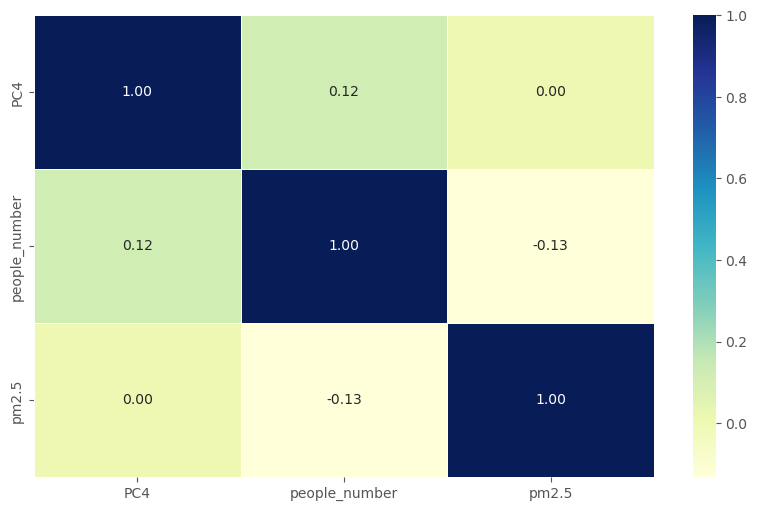

In [20]:
corr_matrix = df_zichtop_air_pollution.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

<h4><font color=mediumvioletred> Get maximum number of people per zip code </font></h4>

In [21]:
max_people = df_zichtop_air_pollution.groupby(["PC4"])["people_number"].agg("max").reset_index()
max_people.head()

PC4  people_number
0  5611        37752.0
1  5612        31431.0
2  5613        27466.0
3  5614        15101.0
4  5615        26376.0

<h4><font color=mediumvioletred> Visualize maximum number of people per zip code </font></h4>

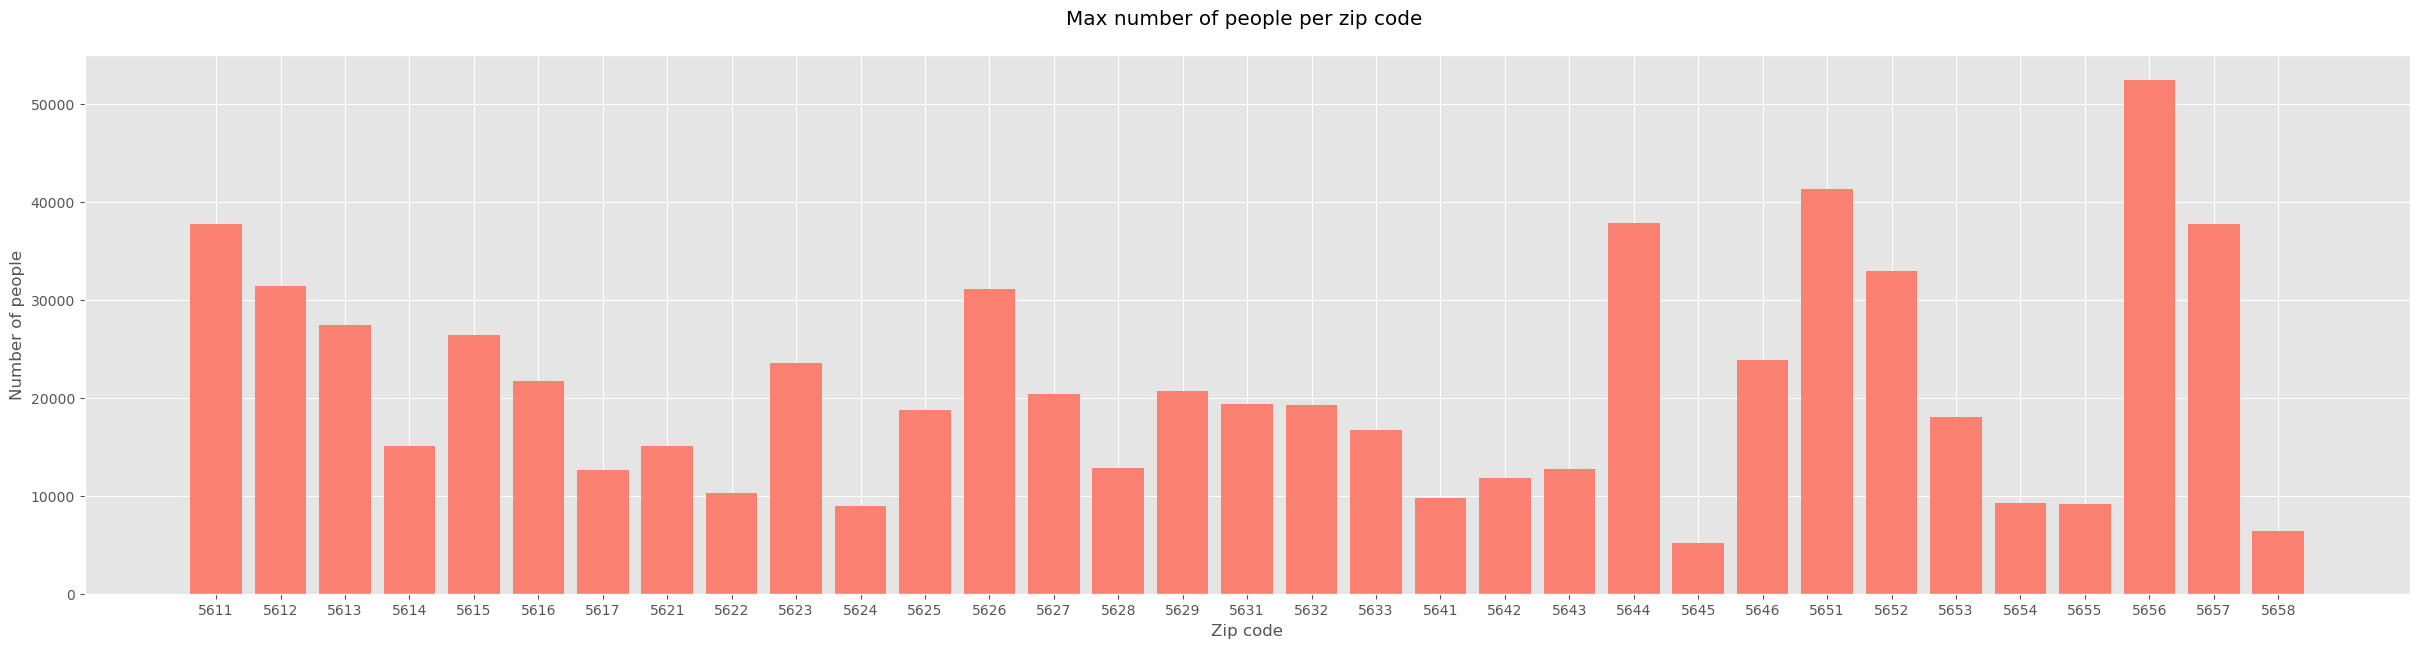

In [22]:
fig, ax = plt.subplots(figsize=(30, 7))
# Plot the data
barplot = ax.bar(max_people["PC4"].astype(str),
                max_people["people_number"],
                color="salmon");

# Customize the plot
ax.set(title="Max number of people per zip code \n",
      xlabel="Zip code",
      ylabel="Number of people");

According to the graph, zip codes 5611, 5644, 5651, 5656 and 5657 have the highest number of people.

<h4><font color=mediumvioletred> Get maximum, average and minimum number of people per zip code </font></h4>

In [23]:
max_mean_min_people = df_zichtop_air_pollution.groupby(["PC4"])["people_number"].agg(["max", "min", "mean"]).reset_index()
max_mean_min_people.head()

PC4      max     min          mean
0  5611  37752.0  1402.0  12313.748447
1  5612  31431.0  1886.0  13679.965839
2  5613  27466.0  1075.0  10201.260870
3  5614  15101.0  1324.0   7251.860248
4  5615  26376.0  1289.0   7879.301242

<h4><font color=mediumvioletred> Visualize maximum, average and minimum number of people per zip code </font></h4>

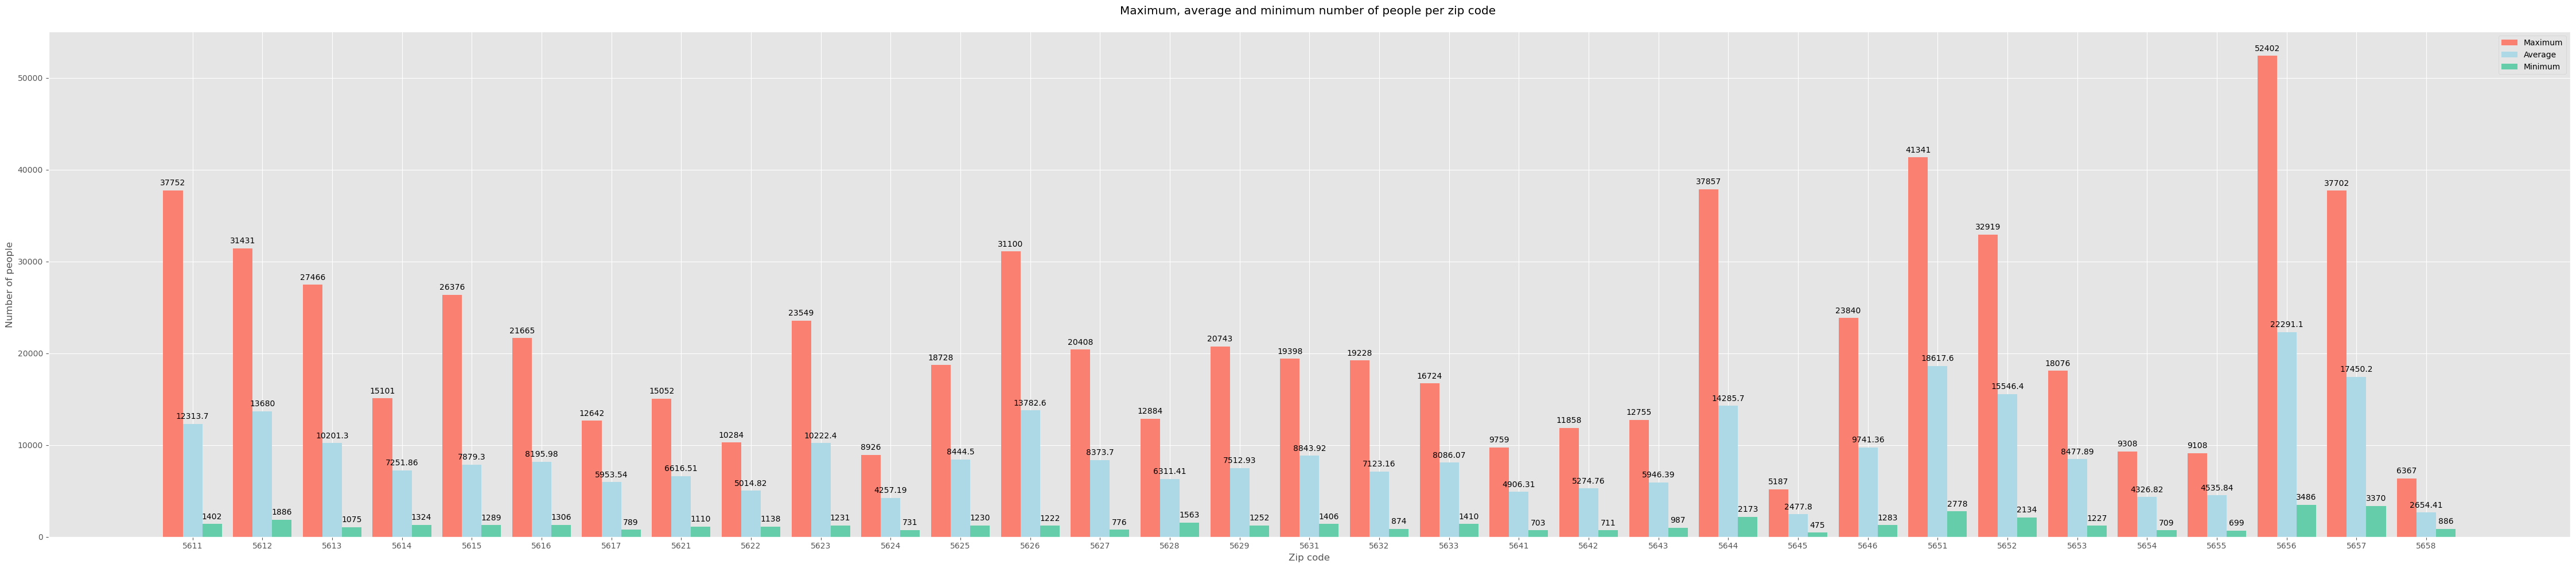

In [24]:
fig, ax = plt.subplots(figsize=(45, 10))

x = np.arange(len(max_mean_min_people["PC4"]))  # the label locations
width = 0.28  # the width of the bars

# Plot the data
rects1 = ax.bar(x - width, max_mean_min_people["max"], width, label="Maximum", color="salmon")
rects2 = ax.bar(x, max_mean_min_people["mean"], width, label="Average", color="lightblue")
rects3 = ax.bar(x + width, max_mean_min_people["min"], width, label="Minimum", color="mediumaquamarine")

# Customize the plot
ax.set_ylabel("Number of people")
ax.set_xlabel("Zip code")
ax.set_title("Maximum, average and minimum number of people per zip code \n")
ax.set_xticks(x, max_mean_min_people["PC4"])
ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=4)
ax.bar_label(rects3, padding=4)

fig.tight_layout()

plt.show()

The graph shows that zip codes 5611, 5644, 5651, 5656 and 5657 have the highest number of people, while zip codes 5645, 5641, 5642, 5654 and 5655 have the lowest number of people.

<h4><font color=mediumvioletred> Get maximum, average and minimum fine inhalable particulate matter per zip code </font></h4>

In [25]:
# Get maximum, average and minimum of pm2.5 per zip code
max_mean_min_pm = df_zichtop_air_pollution.groupby(["PC4"])["pm2.5"].agg(["max", "min", "mean"]).reset_index()
max_mean_min_pm.head()

PC4        max       min       mean
0  5611  57.226658  2.097499  12.161919
1  5612  57.226658  2.097499  12.161919
2  5613  57.226658  2.097499  12.161919
3  5614  57.226658  2.097499  12.161919
4  5615  57.226658  2.097499  12.161919

<h4><font color=mediumvioletred> Visualize maximum, average and minimum fine inhalable particulate matter per zip code </font></h4>

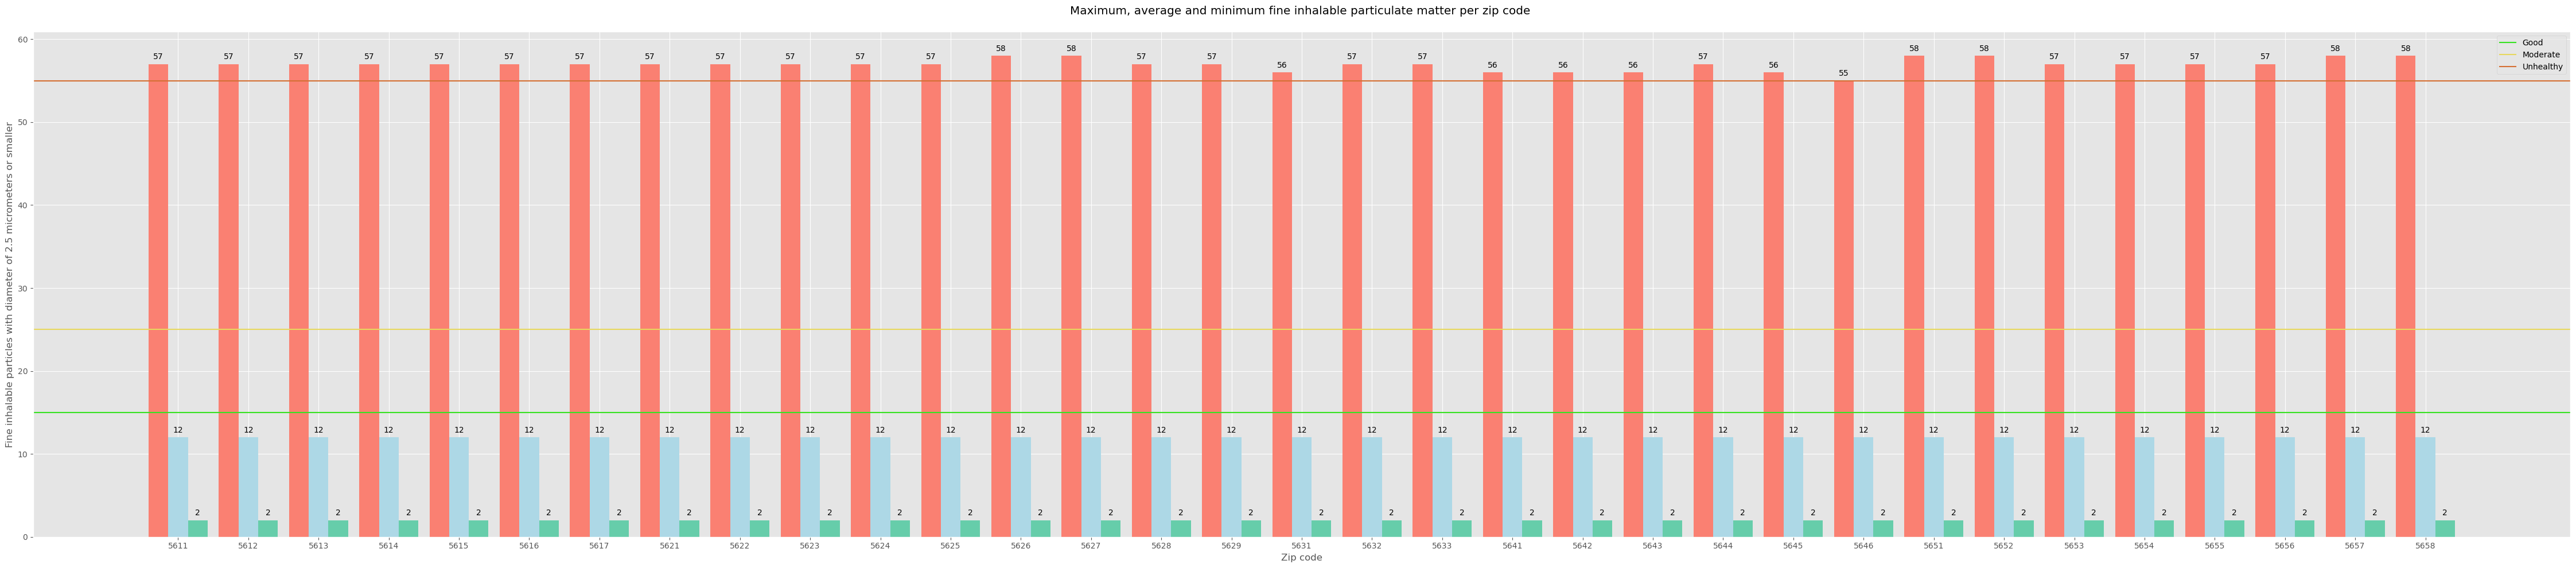

In [26]:
fig, ax = plt.subplots(figsize=(45, 10))

x = np.arange(len(max_mean_min_pm["PC4"]))  # the label locations
width = 0.28  # the width of the bars

# Plot the data
rects1 = ax.bar(x - width, round(max_mean_min_pm["max"]), width, label="Maximum", color="salmon")
rects2 = ax.bar(x, round(max_mean_min_pm["mean"]), width, label="Average", color="lightblue")
rects3 = ax.bar(x + width, round(max_mean_min_pm["min"]), width, label="Minimum", color="mediumaquamarine")

# Customize the plot
ax.set_ylabel("Fine inhalable particles with diameter of 2.5 micrometers or smaller")
ax.set_xlabel("Zip code")
ax.set_title("Maximum, average and minimum fine inhalable particulate matter per zip code \n")
ax.set_xticks(x, max_mean_min_pm["PC4"])
ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=4)
ax.bar_label(rects3, padding=4)

fig.tight_layout()

# adding air quality limits
good_limit = [15]
moderate_limit = [25]
unhealthy_limit = [55]

plt.axhline(y = good_limit, color = '#36e221', linestyle = '-')
plt.axhline(y = moderate_limit, color = '#e7d85d', linestyle = '-')
plt.axhline(y = unhealthy_limit, color = '#d56f33', linestyle = '-')
plt.legend(['Good', 'Moderate', 'Unhealthy'])

plt.show()

The graph indicates, that for each zip code the average and minimum pm2.5 levels are good while the maximum pm2.5 levels are unhealthy.

![title](images/pm2.5_chart.jpg)

<h4><font color=mediumvioletred> Visualize the distribution of population </font></h4>

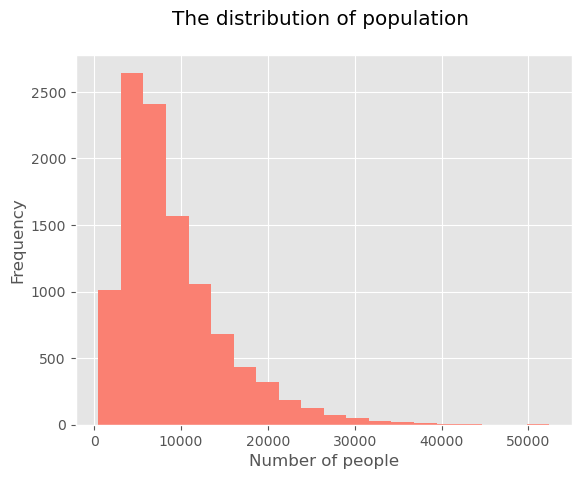

In [27]:
ax = df_zichtop_air_pollution["people_number"].plot.hist(bins=20, 
                                                         title="The distribution of population \n", 
                                                         color="salmon");

ax.set_xlabel("Number of people");

After visualizing the distribution of the population, we can see that there are a few outliers, starting around 40000.

<h4><font color=mediumvioletred> Visualize the distribution of the fine particulate matter (pm2.5) </font></h4>

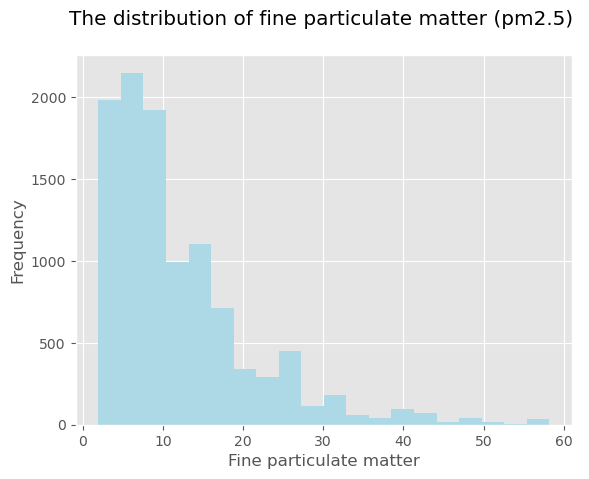

In [28]:
ax = df_zichtop_air_pollution["pm2.5"].plot.hist(bins=20,
                                                title="The distribution of fine particulate matter (pm2.5) \n", 
                                                color="lightblue");

ax.set_xlabel("Fine particulate matter");

We can observe that there are a few outliers in the graph above, starting around 35.

<h4><font color=mediumvioletred> Get number of people and fine particulate matter (pm2.5) for multiple weeks in zip code 5611 </font></h4>

In [29]:
people_pollution_multiple_weeks_5611 = df_zichtop_air_pollution[(df_zichtop_air_pollution["date"] >= "2021-11-01") & 
                                                                    (df_zichtop_air_pollution["date"] < "2021-11-18") & 
                                                                    (df_zichtop_air_pollution["PC4"] == 5611)]
people_pollution_multiple_weeks_5611.sample(5)

PC4        date  people_number      pm2.5
304  5611  2021-11-01         9372.0   6.710862
310  5611  2021-11-07         8005.0   5.374501
311  5611  2021-11-08        11474.0  11.731118
314  5611  2021-11-11        10902.0  48.934731
308  5611  2021-11-05        12134.0  11.695101

<h4><font color=mediumvioletred> Visualize number of people for multiple weeks in zip code 5611 </font></h4>

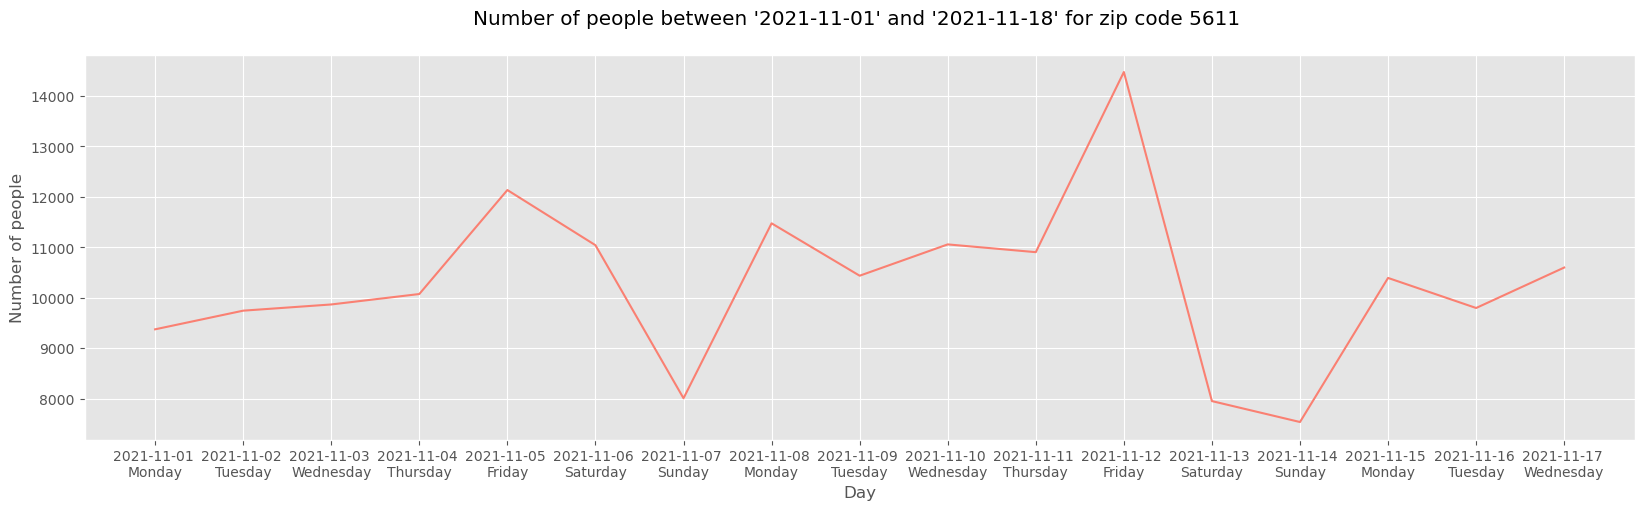

In [30]:
plt.figure(figsize = (20 ,5))

plt.plot(people_pollution_multiple_weeks_5611["date"] + " \n" + pd.DatetimeIndex(people_pollution_multiple_weeks_5611["date"]).day_name(), 
         people_pollution_multiple_weeks_5611["people_number"], color="salmon")
 
# Adding Title to the Plot
plt.title("Number of people between '2021-11-01' and '2021-11-18' for zip code 5611 \n")

# Setting the X and Y labels
plt.xlabel("Day")
plt.ylabel("Number of people")
  
plt.show()

After looking at the population for a few weeks, we can notice a pattern. The number of people balances during the week; it begins to rise on Thursday and peaks on Friday before falling on Saturday, reaching its lowest point on Sunday, and then rising once more on Monday.

<h4><font color=mediumvioletred> Visualize the distribution of population using Boxplot and Histogram</font></h4>

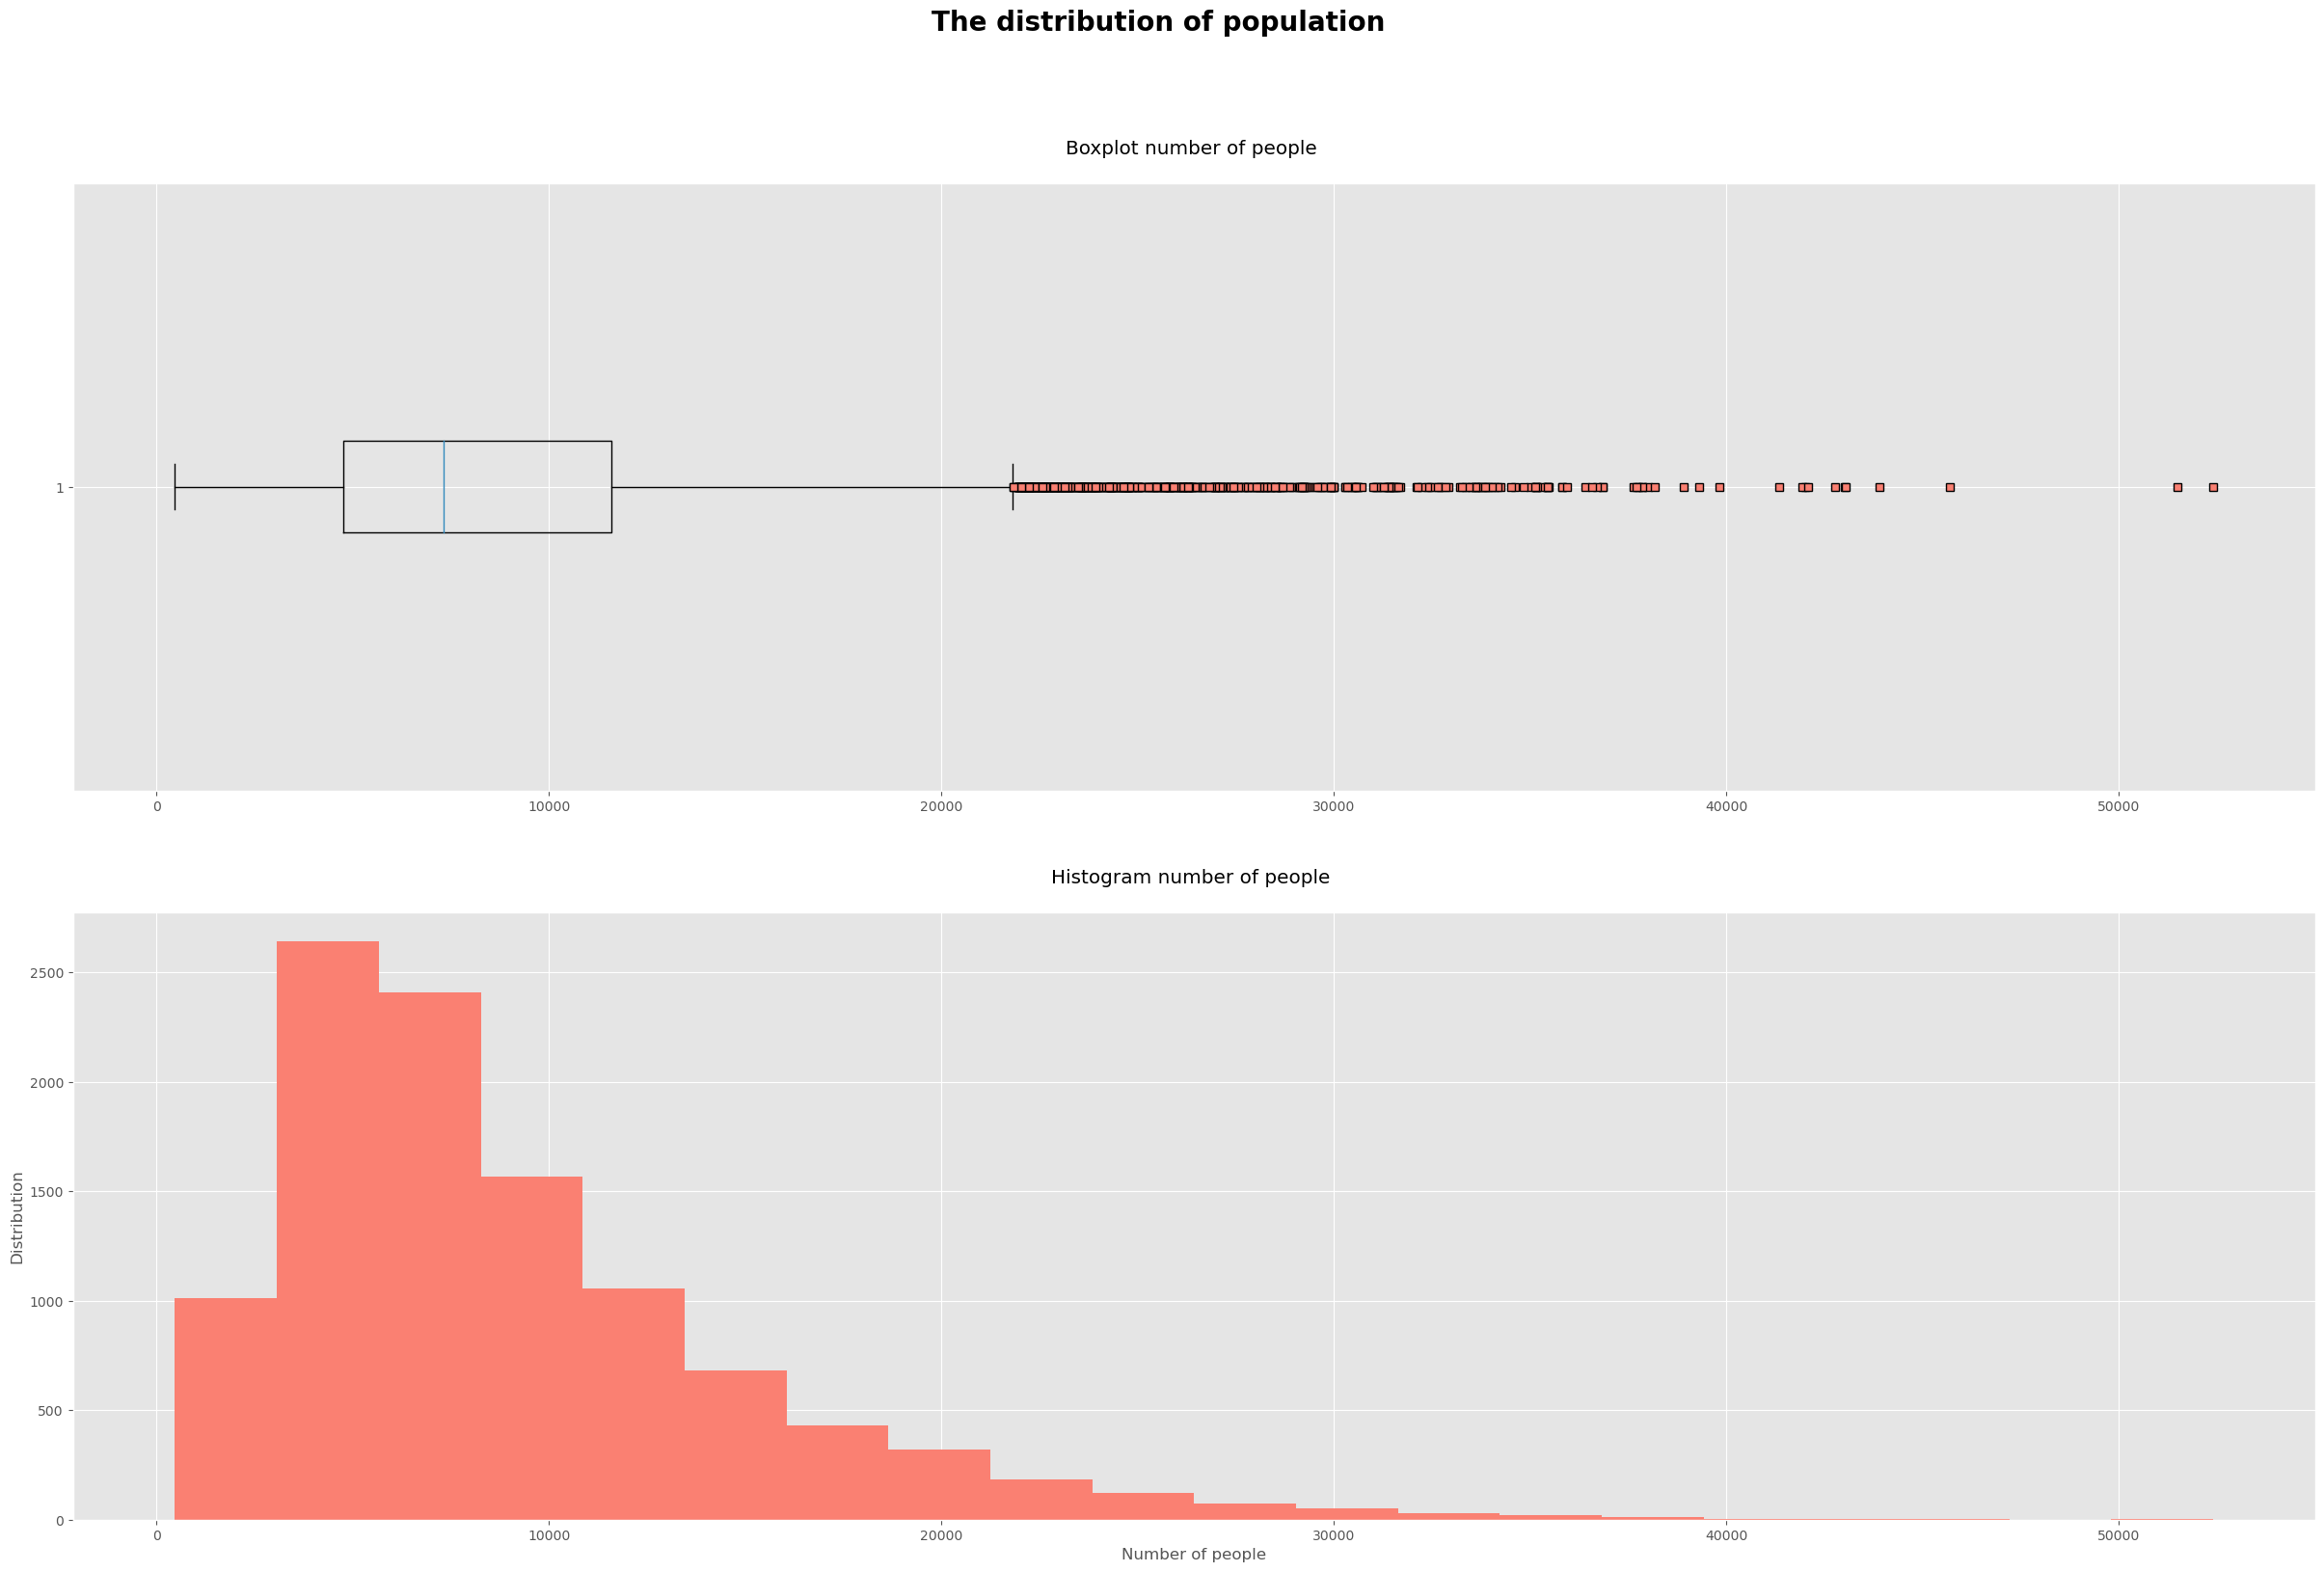

In [31]:
# Subplot of number of people distribution
fig, (ax0, ax1) = plt.subplots(nrows=2,
                                ncols=1,
                                figsize=(30, 18),
                                sharex=False)

# Add data to ax0
red_square = dict(markerfacecolor="salmon", marker="s")
ax0.boxplot(df_zichtop_air_pollution["people_number"], vert=False, flierprops=red_square);
# Add data to ax1
ax1.hist(df_zichtop_air_pollution["people_number"], bins=20, color="salmon");

# Customize ax0
ax0.set(title="Boxplot number of people \n");

# Customize ax1
ax1.set(title="Histogram number of people \n",
        xlabel="Number of people",
        ylabel="Distribution");

# Add a title to the figure
fig.suptitle("The distribution of population", fontsize=20, fontweight="bold");

From the graphs, we can derive that there are a few outliers, starting around 23000.

<h4><font color=mediumvioletred> Visualize the distribution of fine particulate matter using Boxplot and Histogram</font></h4>

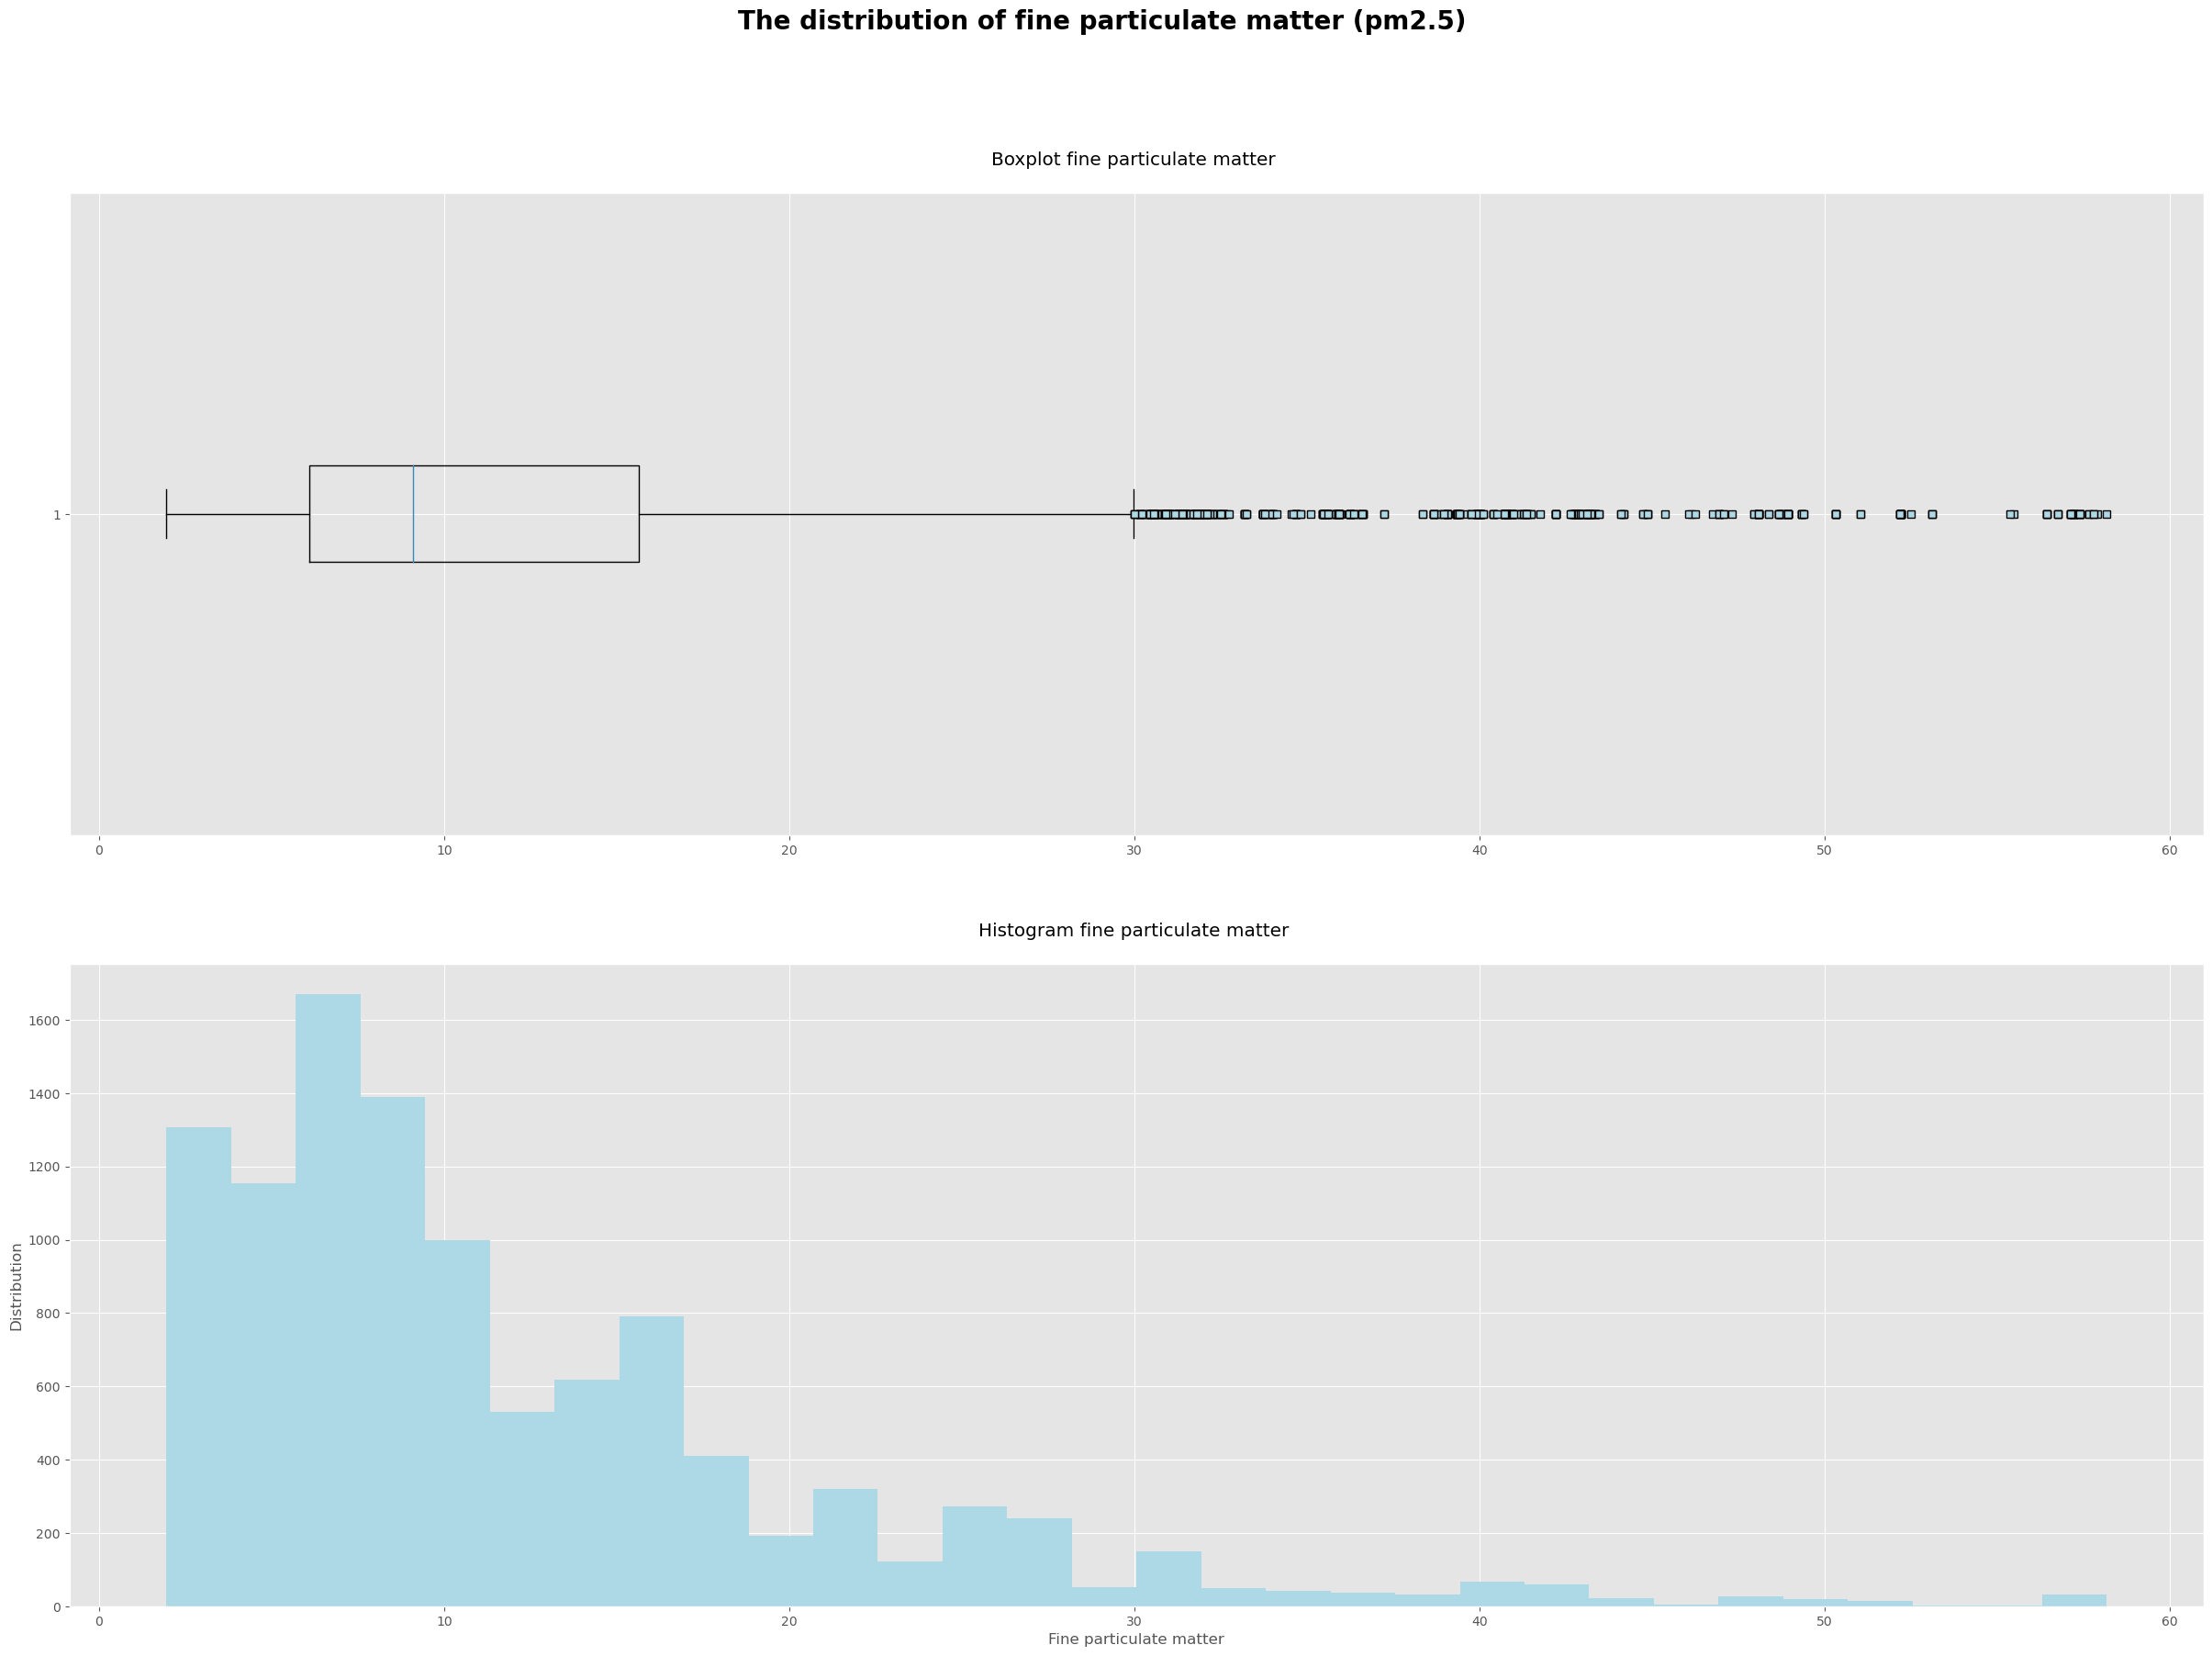

In [32]:
# Subplot of number of people distribution
fig, (ax0, ax1) = plt.subplots(nrows=2,
                                ncols=1,
                                figsize=(30, 20),
                                sharex=False)

# Add data to ax0
red_square = dict(markerfacecolor="lightblue", marker="s")
ax0.boxplot(df_zichtop_air_pollution["pm2.5"], vert=False, flierprops=red_square);
# Add data to ax1
ax1.hist(df_zichtop_air_pollution["pm2.5"], bins=30, color="lightblue");

# Customize ax0
ax0.set(title="Boxplot fine particulate matter \n");

# Customize ax1
ax1.set(title="Histogram fine particulate matter \n",
        xlabel="Fine particulate matter",
        ylabel="Distribution");

# Add a title to the figure
fig.suptitle("The distribution of fine particulate matter (pm2.5)", fontsize=20, fontweight="bold");

From the graphs, we can derive that there are a few outliers, starting around 30.

<h4><font color=mediumvioletred> Visualize the population vs fine particulate matter (pm2.5) per area</font></h4>

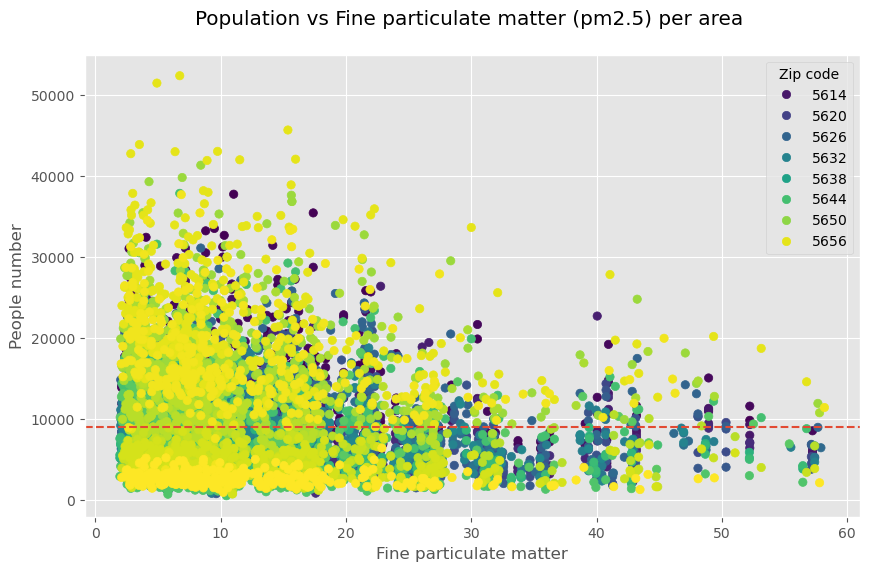

In [33]:
# OO method
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
scatter = ax.scatter(x=df_zichtop_air_pollution["pm2.5"],
                    y=df_zichtop_air_pollution["people_number"],
                    c=df_zichtop_air_pollution["PC4"]);

# Customize the plot
ax.set(title="Population vs Fine particulate matter (pm2.5) per area \n",
      xlabel="Fine particulate matter",
      ylabel="People number");

# Add a legend
ax.legend(*scatter.legend_elements(), title="Zip code");

# Add a horizontal line
ax.axhline(df_zichtop_air_pollution["people_number"].mean(),
          linestyle="--");

The above scatter plot confirms our previous findings, that both the people number and fine particulate matter have some outliers which need to be handled in order to produce an accurate model.

<h4><font color=mediumvioletred>Specify country code in Pgeocode library </font></h4>

In [34]:
nomi = pgeocode.Nominatim('nl')

<h4><font color=mediumvioletred>Get postal code information for zip code 5621 </font></h4>

In [35]:
nomi.query_postal_code("5621")

postal_code                5621
country_code                 NL
place_name            Eindhoven
state_name        Noord-Brabant
state_code                    6
county_name           Eindhoven
county_code                 772
community_name              NaN
community_code              NaN
latitude                51.4549
longitude                 5.457
accuracy                    6.0
Name: 0, dtype: object

<h4><font color=mediumvioletred>Get sample of of zichtop air pollution dataframe </font></h4>

In [36]:
df_zichtop_air_pollution.sample(5)

PC4        date  people_number      pm2.5
6227  5641  2021-04-20         5503.0  40.725185
4413  5627  2021-08-16         9817.0   4.022686
6871  5643  2021-04-20         5384.0  40.725185
654   5613  2021-01-11         5015.0  22.936346
9676  5656  2021-01-17        12476.0  16.632364

<h4><font color=mediumvioletred>Create a new dataframe containing unique zip codes </font></h4>

In [37]:
zipcodes = pd.DataFrame({"PC4": df_zichtop_air_pollution["PC4"].unique()})
zipcodes.head(5)

PC4
0  5611
1  5612
2  5613
3  5614
4  5615

<h4><font color=mediumvioletred>Add latitude, longitude data to the zip codes dataframe </font></h4>

In [38]:
# add latitude, longitude data to the dataframe
zipcodes["latitude"] = zipcodes["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
zipcodes["longitude"] = zipcodes["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [39]:
zipcodes["PC4"] = zipcodes["PC4"].astype("str")

<h4><font color=mediumvioletred>Get sample of zip codes </font></h4>

In [40]:
zipcodes.sample(5)

PC4  latitude  longitude
26  5652   51.4394     5.4380
9   5623   51.4595     5.4782
10  5624   51.4696     5.4570
31  5657   51.4512     5.4008
4   5615   51.4293     5.4746

<h4><font color=mediumvioletred>Plot the map with the latitude, longitude and zip code in Eindhoven</font></h4>

In [41]:
fig = px.scatter_mapbox(zipcodes, 
                        title="Eindhoven map with latitude, longitude and zip code", 
                        lat="latitude", 
                        lon="longitude", 
#                         text="PC4", 
                        hover_name="PC4", 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred>Get min and max number of people per area</font></h4>

In [42]:
min_max_people_per_area = df_zichtop_air_pollution.groupby(["PC4"])["people_number"].agg(["max", "min"]).rename(columns={'max': 'max_number_people', "min": "min_number_people"}).reset_index()
min_max_people_per_area.head(5)

PC4  max_number_people  min_number_people
0  5611            37752.0             1402.0
1  5612            31431.0             1886.0
2  5613            27466.0             1075.0
3  5614            15101.0             1324.0
4  5615            26376.0             1289.0

<h4><font color=mediumvioletred>Add latitude, longitude data to the min_max_people_per_area dataframe </font></h4>

In [43]:
min_max_people_per_area["latitude"] = min_max_people_per_area["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
min_max_people_per_area["longitude"] = min_max_people_per_area["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [44]:
min_max_people_per_area["PC4"] = min_max_people_per_area["PC4"].astype("str")

<h4><font color=mediumvioletred>Get sample of min_max_people_per_area </font></h4>

In [45]:
min_max_people_per_area.sample(5)

PC4  max_number_people  min_number_people  latitude  longitude
30  5656            52402.0             3486.0   51.4112     5.4561
21  5643            12755.0              987.0   51.4235     5.5011
20  5642            11858.0              711.0   51.4389     5.5144
28  5654             9308.0              709.0   51.4215     5.4582
32  5658             6367.0              886.0   51.4405     5.4098

<h4><font color=mediumvioletred>Plot the map with the latitude, longitude, zip code, minimum and maximum number of people in Eindhoven</font></h4>

In [46]:
fig = px.scatter_mapbox(min_max_people_per_area, 
                        title="Eindhoven map with latitude, longitude, zip code, maximum and minimum number of people", 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="PC4", 
                        hover_data=["min_number_people"], 
                        color="max_number_people", 
                        size="max_number_people", 
                        color_continuous_scale=px.colors.diverging.balance, 
                        size_max=15, 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred>People vs. pollution on 25-09-2021 </font></h4>

In [47]:
# Calculate people number (sum) and pm2.5 (average) on 2021-09-25
people_pollution_per_day = df_zichtop_air_pollution[df_zichtop_air_pollution.date == "2021-09-25"].reset_index(drop=True)
# Round to 2 decimal places
people_pollution_per_day = people_pollution_per_day.round(decimals=2)

people_pollution_per_day.head(5)

PC4        date  people_number  pm2.5
0  5611  2021-09-25        16501.0   8.59
1  5612  2021-09-25        23022.0   8.59
2  5613  2021-09-25        14987.0   8.59
3  5614  2021-09-25        10039.0   8.59
4  5615  2021-09-25        11540.0   8.59

<h4><font color=mediumvioletred>Add latitude, longitude data to the people_pollution_per_day dataframe </font></h4>

In [48]:
people_pollution_per_day["latitude"] = people_pollution_per_day["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
people_pollution_per_day["longitude"] = people_pollution_per_day["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [49]:
people_pollution_per_day["PC4"] = people_pollution_per_day["PC4"].astype("str")

<h4><font color=mediumvioletred>Plot the map with the latitude, longitude, zip code, number of people and fine inhalable particulate matter in Eindhoven</font></h4>

In [50]:
fig = px.scatter_mapbox(people_pollution_per_day, 
                        title="Number of people vs. fine inhalable particulate matter per zip code in Eindhoven on 25-09-2021", 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="PC4", 
                        color="pm2.5", 
                        size="people_number", 
                        color_continuous_scale=px.colors.diverging.balance, 
                        size_max=15, 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred> Conclusion </font></h4>

After exploring and visualizing the zichtop dataset, we conclude that the only relevant columns to use in the following steps are  date, PC4 (zip code) and a new column called people_number (m00_30 + m30_60).

We need this new column because we want to group data per area and date and currently pop_tot column is the result of the sum of the following columns (m00_30, m30_60, H1_2, H2_4, H4_8, H8_16 and H16plus), so the same people are counted multiple times throughout the day and that will result in inaccurate number of people.

<h3><font color=steelblue>Meteo dataset</font></h3>

<h4><font color=mediumvioletred>Read CSV files and get meteo data sample</font></h4>

In [51]:
df_meteo = pd.read_csv("data/meteo.csv")
df_air_pollution = pd.read_csv("data/air_pollution.csv")
df_meteo.sample(10)

date   PC4          wd        ws          blh  \
195421  2021-04-23 13:00:00  5644   82.164185  2.559096  1100.095581   
108404  2021-05-17 20:00:00  5626  184.316498  2.311202   275.423553   
249207  2021-06-13 15:00:00  5654   81.154716  1.393683  1190.487061   
232028  2021-06-27 20:00:00  5652  337.518646  2.068910   277.731049   
114496  2021-01-26 16:00:00  5627  208.582733  3.310350   564.913208   
103652  2021-10-31 20:00:00  5625  229.426208  4.670274  1229.304199   
38054   2021-05-06 14:00:00  5615  180.844254  1.325073  1383.289429   
236319  2021-12-23 15:00:00  5652  215.936874  4.971998   414.518860   
170178  2021-06-05 18:00:00  5641  148.302643  4.507399   606.427917   
213680  2021-05-24 08:00:00  5646  258.967682  5.839763  1169.389771   

             tcc        ssrd  
195421  0.014369  762.911875  
108404  0.331397    3.407181  
249207  0.000000  685.976875  
232028  0.990252    5.990815  
114496  0.905751   45.212543  
103652  0.662866    0.000000  
38054   0.972899  459.263993  
236319  0.998389   41.007049  
170178  0.360823  181.561615  
213680  0.996279  197.829531

<h4><font color=mediumvioletred>Get air pollution data sample</font></h4>

In [52]:
df_air_pollution.sample(10)

date   PC4       pm10      pm2.5        no2         no  \
86     2021-09-28 14:00:00  5611  10.872298   4.264615  17.238621  11.278460   
51407  2021-11-28 23:00:00  5657  17.970989  14.230954  58.339933  38.169212   
34139  2021-10-10 11:00:00  5643  44.342789  38.485058  20.754897  13.579002   
68149  2021-12-20 12:00:00  5612  21.974420  14.483290  10.031483   2.917601   
26309  2021-10-19 05:00:00  5631  10.545179   4.935512  23.484032  15.364553   
28784  2021-11-24 08:00:00  5632  33.885876  31.223143  34.821836  22.782371   
48526  2021-10-06 22:00:00  5656  17.525806   9.428202  45.692239  29.894390   
14045  2021-11-13 05:00:00  5622   3.759254   3.293751   9.615114   6.290739   
74257  2021-12-27 00:00:00  5651  29.576550  58.405690  35.672718   3.944973   
27914  2021-10-19 02:00:00  5632   2.557969   2.333679   8.562138   5.601825   

            so2  
86     1.411488  
51407  5.401647  
34139  0.438855  
68149  1.330161  
26309  5.946470  
28784  7.554442  
48526  3.173471  
14045  1.115311  
74257  0.883436  
27914  2.951669

<h4><font color=mediumvioletred>Show all postal codes</font></h4>

In [53]:
df_meteo['PC4'].unique()

array([5611, 5612, 5613, 5614, 5615, 5616, 5617, 5621, 5622, 5623, 5624,
       5625, 5626, 5627, 5628, 5629, 5631, 5632, 5633, 5641, 5642, 5643,
       5644, 5645, 5646, 5651, 5652, 5653, 5654, 5655, 5656, 5657, 5658],
      dtype=int64)

The dataset contains data from 33 different postal code areas

<h4><font color=mediumvioletred>Show the shape of the meteo data</font></h4>

In [54]:
df_meteo.shape

(289080, 7)

<h4><font color=mediumvioletred>Show all datatypes of meteo data</font></h4>

In [55]:
df_meteo['date'] = pd.to_datetime(df_meteo['date'])
df_air_pollution['date'] = pd.to_datetime(df_air_pollution['date'])
df_meteo.dtypes

date    datetime64[ns]
PC4              int64
wd             float64
ws             float64
blh            float64
tcc            float64
ssrd           float64
dtype: object

<h4><font color=mediumvioletred>Filter meteo data on single postal code and get a sample</font></h4>

In [56]:
postalcode_df_meteo = df_meteo[df_meteo['PC4'] == 5611]
postalcode_df_meteo.sample(10)

date   PC4          wd        ws          blh       tcc  \
2833 2021-04-29 01:00:00  5611   64.415962  4.052329   408.564026  0.498803   
2943 2021-05-03 15:00:00  5611  227.061569  5.957564  2070.624512  1.000000   
500  2021-01-21 20:00:00  5611  298.990540  3.178622   767.104858  1.000000   
1816 2021-03-17 16:00:00  5611   96.736923  4.972317   802.710083  0.546211   
3602 2021-05-31 02:00:00  5611   18.512978  2.914060   169.436234  0.000000   
5467 2021-08-16 19:00:00  5611  168.383591  5.149878   980.559021  0.346754   
7486 2021-11-08 22:00:00  5611  232.198837  1.814999    77.876625  0.755073   
6974 2021-10-18 14:00:00  5611  280.516571  3.235554   431.540100  0.978214   
4364 2021-07-01 20:00:00  5611  187.479752  2.717148   553.020569  0.993561   
6436 2021-09-26 04:00:00  5611  278.956879  2.184699   102.874001  0.842213   

            ssrd  
2833    0.000000  
2943  249.341510  
500     0.000000  
1816  199.000851  
3602    0.000000  
5467   28.400414  
7486    0.000000  
6974  194.434635  
4364    9.045193  
6436    0.000000

In this sample the solar surface radiation downawrd (ssrd) shows the value 0.000000. After researching this, it is normal since the sensor can measure this during 6 p.m. and 6 a.m.

<h4><font color=mediumvioletred>Show standard distribution of boundary layer height data</font></h4>

Skewness per column:
PC4     0.133640
wd     -0.214002
ws      0.931107
blh     1.054221
tcc    -0.894305
ssrd    1.656176
dtype: float64


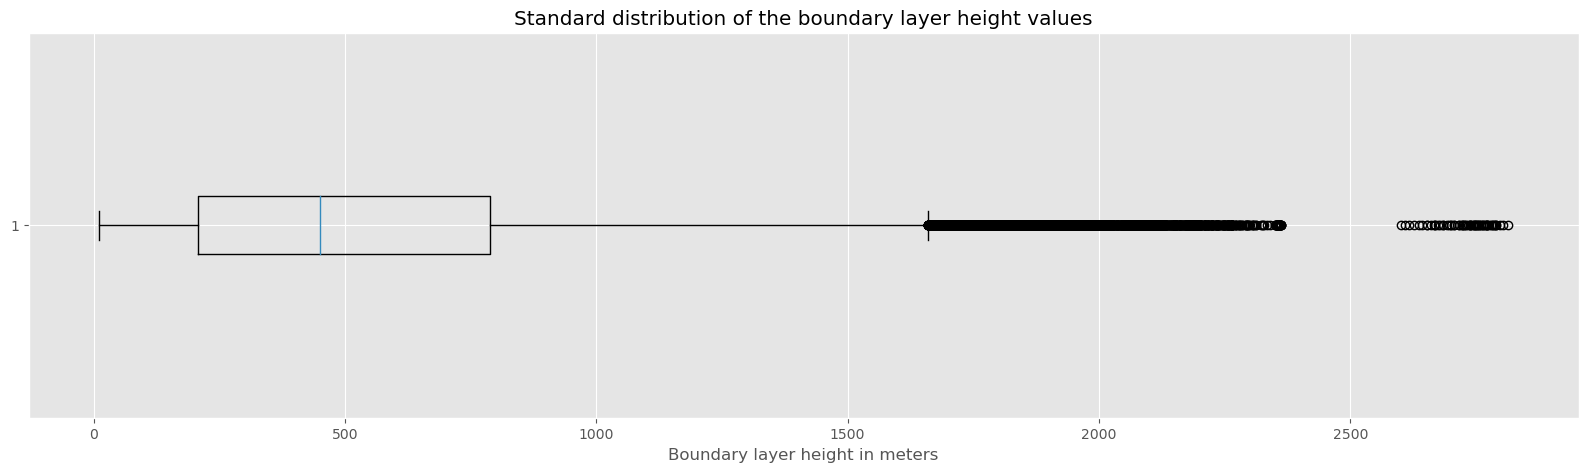

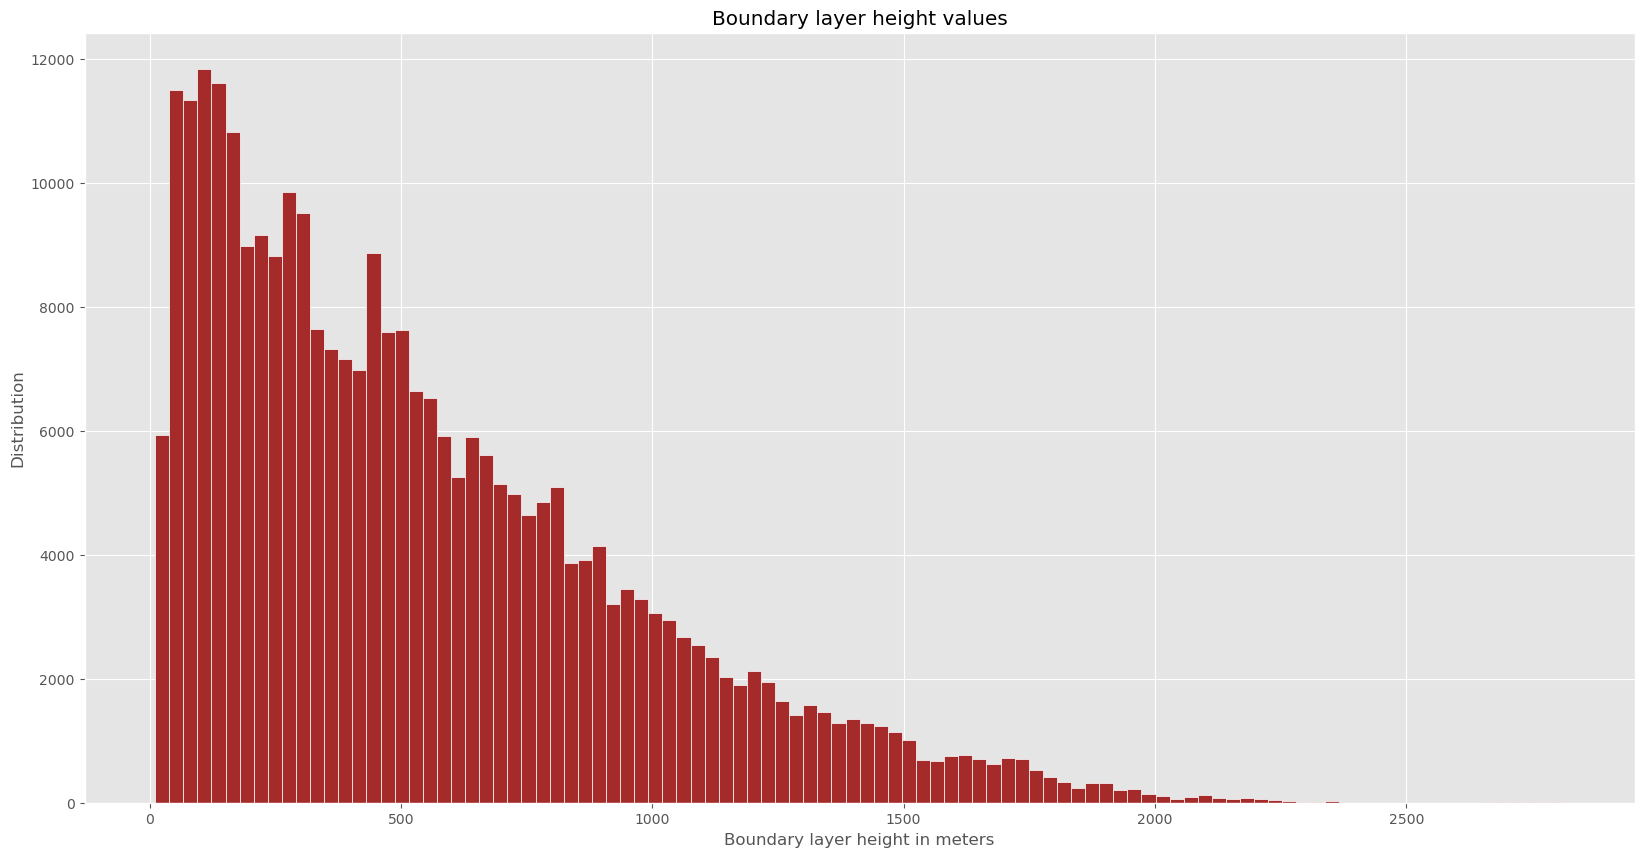

In [57]:
print("Skewness per column:")
print(df_meteo.skew(numeric_only=True))

plt.figure(figsize=(20,5))
plt.boxplot(df_meteo['blh'], vert=False)
plt.title("Standard distribution of the boundary layer height values")
plt.xlabel("Boundary layer height in meters")
plt.show()

plt.figure(figsize=(20,10))
plt.hist(df_meteo['blh'], edgecolor='white', color='brown', bins=100)
plt.title("Boundary layer height values")
plt.xlabel("Boundary layer height in meters")
plt.ylabel("Distribution")
plt.show()

The graphs represent the distribution of the boundary layer height data. The skewness of these graphs are positive. Most of the boundary layer heights are close to zero. You also don't see a lot of outliers on the bottom graph, since the tail of data is not long. This means that the distribution is devided relatively evenly.

<h4><font color=mediumvioletred>Visualize windspeed compared to solar surface radiation downwards</font></h4>

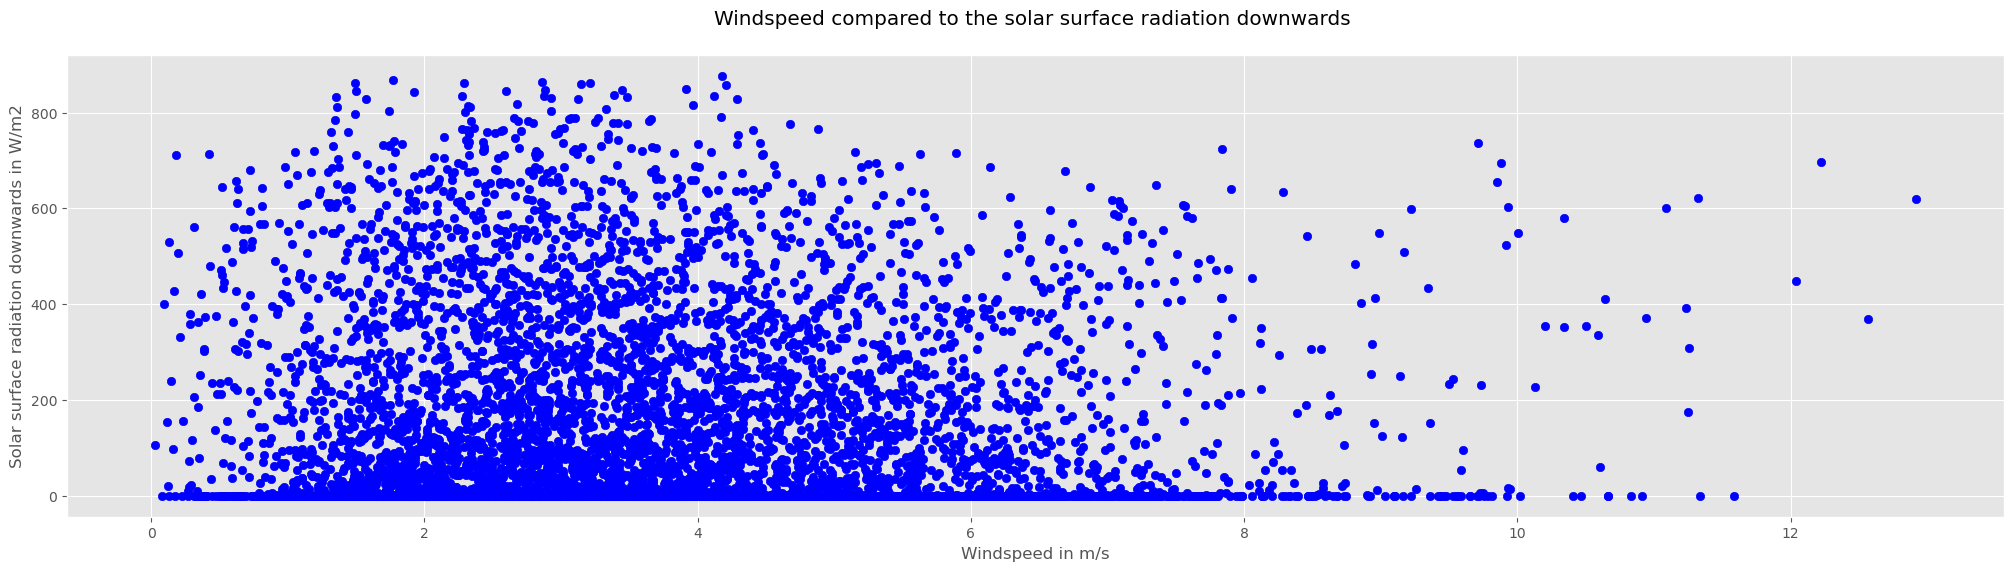

In [58]:
fig, ax = plt.subplots(figsize=(25, 6))
scatter = ax.scatter((postalcode_df_meteo["ws"]),
                list(postalcode_df_meteo["ssrd"]),
                color="blue")

ax.set(title="Windspeed compared to the solar surface radiation downwards \n",
      xlabel="Windspeed in m/s",
      ylabel="Solar surface radiation downwards in W/m2");

In the graph above you can see that the solar surface rediation downwards (ssrd) almost doesn't appear when the windspeed is above 8m/s. So there is a visable correlation between the windspeed and ssrd. It also shows the 0.000000 values of the ssrd.

<h4><font color=mediumvioletred>Visualize windspeed in September from postal code 5611</font></h4>

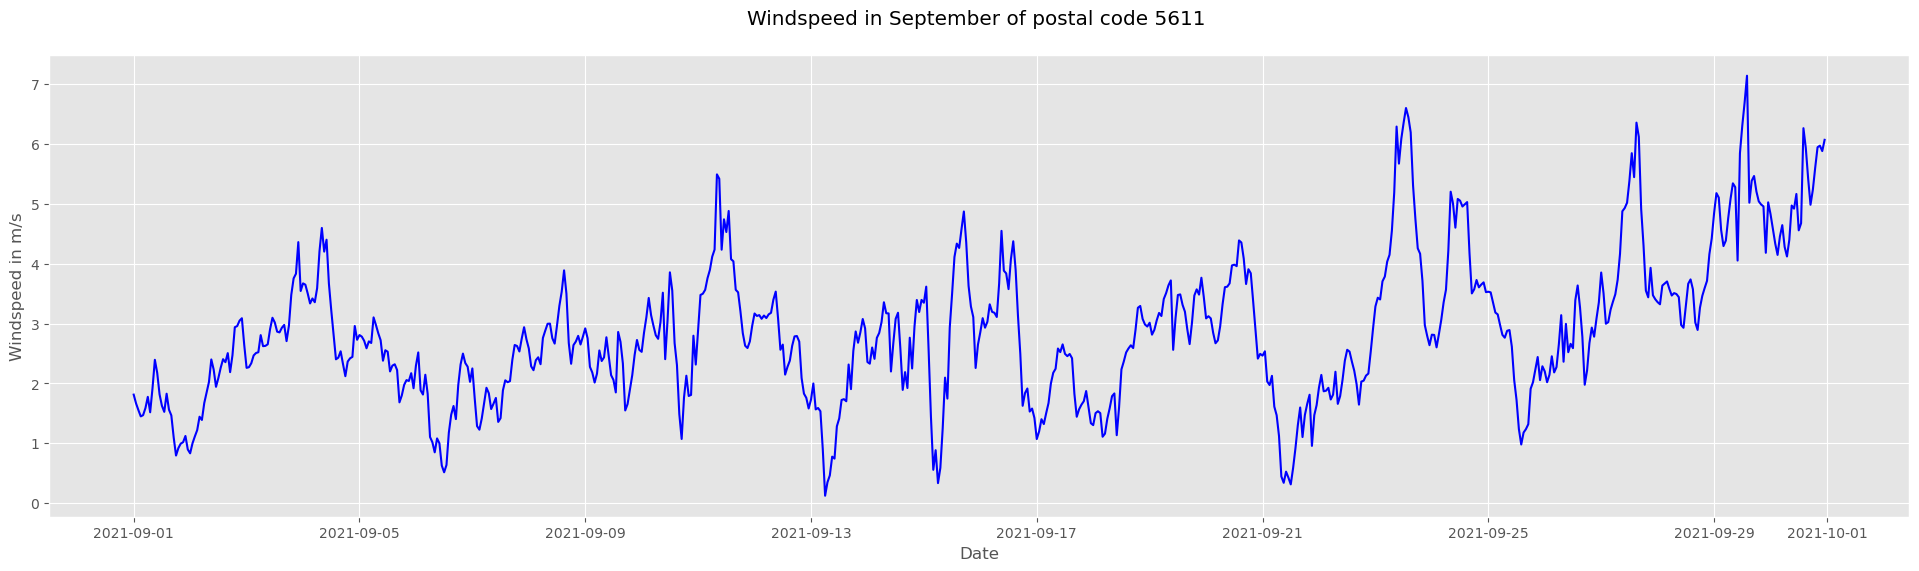

In [59]:
one_month_postalcode_df_meteo = postalcode_df_meteo[postalcode_df_meteo['date']. dt. strftime('%Y-%m')=='2021-09']

fig, ax = plt.subplots(figsize=(24, 6))
plot = ax.plot(list(one_month_postalcode_df_meteo["date"]),
                list(one_month_postalcode_df_meteo["ws"]),
                color="blue")

ax.set(title="Windspeed in September of postal code 5611 \n",
      xlabel="Date",
      ylabel="Windspeed in m/s");

No real conclusion can be drawn from just looking at the windspeed data. 

<h4><font color=mediumvioletred>Merge meteo and air pollution dataset and show sample</font></h4>

In [60]:
df_meteo_air_pollution = pd.merge(df_meteo, df_air_pollution[['PC4','date', 'pm10', 'pm2.5', 'no2',	'no', 'so2']], on=['PC4', 'date'])
df_meteo_air_pollution.sample(10)

date   PC4          wd        ws          blh       tcc  \
22303 2021-11-20 07:00:00  5623  223.688034  2.559613   276.133179  0.939623   
514   2021-10-16 10:00:00  5611  257.769623  1.909065  1327.579712  0.720598   
21473 2021-10-16 17:00:00  5623  256.897064  2.076972   157.696915  0.963290   
66389 2021-11-14 05:00:00  5654   43.699467  2.346491   228.526306  1.000000   
3679  2021-11-20 07:00:00  5612  223.701935  2.539988   272.413696  0.944850   
44485 2021-10-05 13:00:00  5641  271.752045  6.517864  1060.373047  1.000000   
56193 2021-10-08 09:00:00  5646   24.221943  1.522663   152.331757  0.062932   
46915 2021-10-09 19:00:00  5642   19.110113  2.304944   107.883987  0.184729   
34626 2021-12-18 17:00:00  5628   80.081337  1.861125   249.554321  1.000000   
13915 2021-12-28 18:00:00  5616  176.123260  5.136837   688.445923  0.909082   

             ssrd       pm10      pm2.5        no2         no        so2  
22303    0.000000  30.416098  18.336990  34.535777  22.595216   3.593178  
514    225.380434  11.579887   4.781002  30.718383  20.097665   0.318577  
21473   10.108496  13.617803   8.144045  50.411498  32.981991   2.503156  
66389    0.000000  32.070324  28.259674  29.054975  19.009372   0.006652  
3679     0.000000  32.094543  19.725561  36.394219  23.811112   3.692149  
44485  133.012726   2.178857   1.707692   8.986788   5.879654   0.424841  
56193  202.349705  49.791931  46.490974  30.331366  19.844457   0.328770  
46915    0.000000  38.813034  23.528187  51.820365  33.903749  10.272394  
34626    0.000000  25.707100  41.531890  26.106451   0.315530   0.228048  
13915    0.000000   9.536153  13.679080  20.038290   0.149736   1.037323

<h4><font color=mediumvioletred>Show corrolation between merged meteo and air pollution data</font></h4>

In [61]:
df_meteo_air_pollution.corr(method='spearman')

PC4        wd        ws       blh       tcc      ssrd      pm10  \
PC4    1.000000 -0.000203 -0.001175 -0.000395 -0.000085  0.000106 -0.026865   
wd    -0.000203  1.000000  0.190082  0.048322  0.050032  0.032333 -0.148475   
ws    -0.001175  0.190082  1.000000  0.807271  0.176822  0.073962 -0.607904   
blh   -0.000395  0.048322  0.807271  1.000000  0.200182  0.341155 -0.615602   
tcc   -0.000085  0.050032  0.176822  0.200182  1.000000  0.001251 -0.031441   
ssrd   0.000106  0.032333  0.073962  0.341155  0.001251  1.000000 -0.059004   
pm10  -0.026865 -0.148475 -0.607904 -0.615602 -0.031441 -0.059004  1.000000   
pm2.5 -0.028674 -0.106274 -0.472557 -0.542800  0.110042 -0.158170  0.886844   
no2   -0.034462 -0.161741 -0.591700 -0.655762 -0.105527 -0.206825  0.560476   
no    -0.027125 -0.109364 -0.499212 -0.502562 -0.186421 -0.049303  0.283385   
so2    0.004346 -0.008121 -0.212465 -0.337730 -0.208994 -0.076840  0.336788   

          pm2.5       no2        no       so2  
PC4   -0.028674 -0.034462 -0.027125  0.004346  
wd    -0.106274 -0.161741 -0.109364 -0.008121  
ws    -0.472557 -0.591700 -0.499212 -0.212465  
blh   -0.542800 -0.655762 -0.502562 -0.337730  
tcc    0.110042 -0.105527 -0.186421 -0.208994  
ssrd  -0.158170 -0.206825 -0.049303 -0.076840  
pm10   0.886844  0.560476  0.283385  0.336788  
pm2.5  1.000000  0.431592  0.014917  0.189855  
no2    0.431592  1.000000  0.735620  0.394545  
no     0.014917  0.735620  1.000000  0.371746  
so2    0.189855  0.394545  0.371746  1.000000

With the spearman method, it can be noted that the particulate matter smaller than 2.5 micrometer (pm2.5) has the most corrolation with the boundary layer height (blh), the windspeed (ws), and nitrogen dioxide in ug/m3 (no2).

<h4><font color=mediumvioletred>Show corrolation between particulate matter smaller than 2.5 um and windspeed</font></h4>

-0.4220468437258586


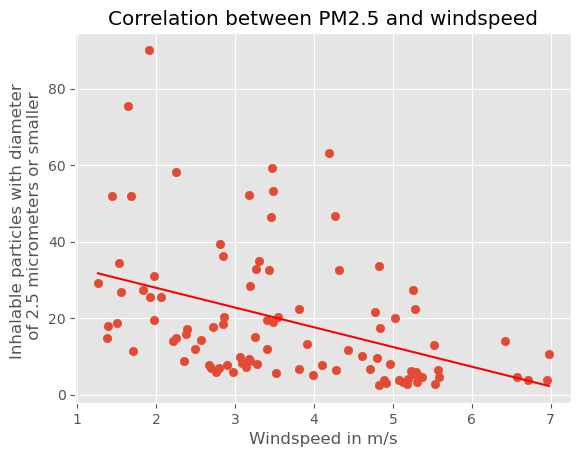

In [62]:
group_by_day = df_meteo_air_pollution.groupby(pd.Grouper(freq='D', key='date')).mean()
ws_pm25_corr = group_by_day["ws"].corr(group_by_day["pm2.5"])
print(ws_pm25_corr)
plt.scatter(group_by_day["ws"], group_by_day["pm2.5"])
plt.plot(np.unique(group_by_day["ws"]), np.poly1d(np.polyfit(group_by_day["ws"], group_by_day["pm2.5"], 1))
         (np.unique(group_by_day["ws"])), color='red')
plt.title('Correlation between PM2.5 and windspeed')
plt.xlabel('Windspeed in m/s')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller');
# Particulate matter <2.5um in ug/m3

The inhalable particles with diameter of 2.5 micrometers or smaller keep decreasing when the windspeed keep increasing. So there is a low negative correlation between the two. Which means with higher wind speeds there are less particals of 2.5 micrometers or smaller in the air.

<h4><font color=mediumvioletred>Show corrolation between particulate matter smaller than 2.5 um and boundary layer height</font></h4>

-0.5270951619288825


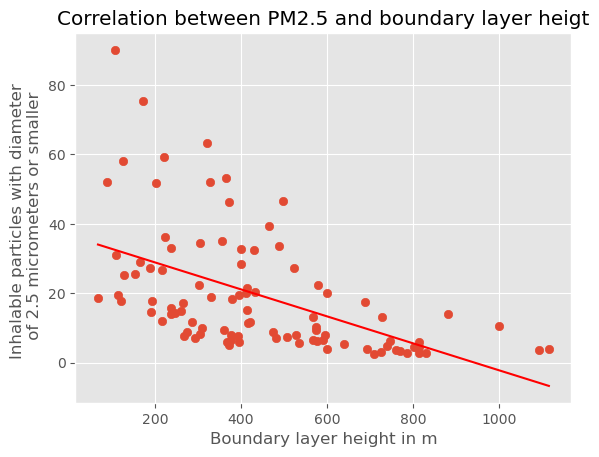

In [63]:
group_by_day = df_meteo_air_pollution.groupby(pd.Grouper(freq='D', key='date')).mean()
ws_pm25_corr = group_by_day["blh"].corr(group_by_day["pm2.5"])
print(ws_pm25_corr)
plt.scatter(group_by_day["blh"], group_by_day["pm2.5"])
plt.plot(np.unique(group_by_day["blh"]), np.poly1d(np.polyfit(group_by_day["blh"], group_by_day["pm2.5"], 1))
         (np.unique(group_by_day["blh"])), color='red')
plt.title('Correlation between PM2.5 and boundary layer heigt')
plt.xlabel('Boundary layer height in m')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller');
# Particulate matter <2.5um in ug/m3

The inhalable particles with diameter of 2.5 micrometers or smaller keep decreasing when the boundary layer height keeps increasing. So there is a low negative correlation between the two. Which means that how higher the boundary layer, the less there are particles of 2.5 micrometer or smaller in the air.

<h4><font color=mediumvioletred>Show corrolation between particulate matter smaller than 2.5 um and solar surface radiation downwards</font></h4>

-0.44465439902953424


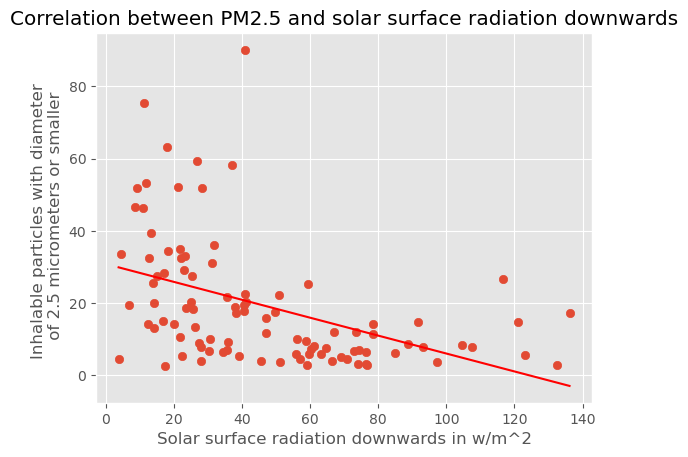

In [64]:
group_by_day = df_meteo_air_pollution.groupby(pd.Grouper(freq='D', key='date')).mean()
ws_pm25_corr = group_by_day["ssrd"].corr(group_by_day["pm2.5"])
print(ws_pm25_corr)
plt.scatter(group_by_day["ssrd"], group_by_day["pm2.5"])
plt.plot(np.unique(group_by_day["ssrd"]), np.poly1d(np.polyfit(group_by_day["ssrd"], group_by_day["pm2.5"], 1))
         (np.unique(group_by_day["ssrd"])), color='red')
plt.title('Correlation between PM2.5 and solar surface radiation downwards')
plt.xlabel('Solar surface radiation downwards in w/m^2')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller');
# Particulate matter <2.5um in ug/m3

The inhalable particles with diameter of 2.5 micrometers or smaller keep decreasing when the solar surface radiation keep increasing. So there is a low negative correlation between the two. Which means that the higher the solar surface radiation is the less there are particles smaller than 2.5 micrometer in the air.

<h4><font color=mediumvioletred> Visualize the boundary layer height for the first week of November of postal code 5611</font></h4>

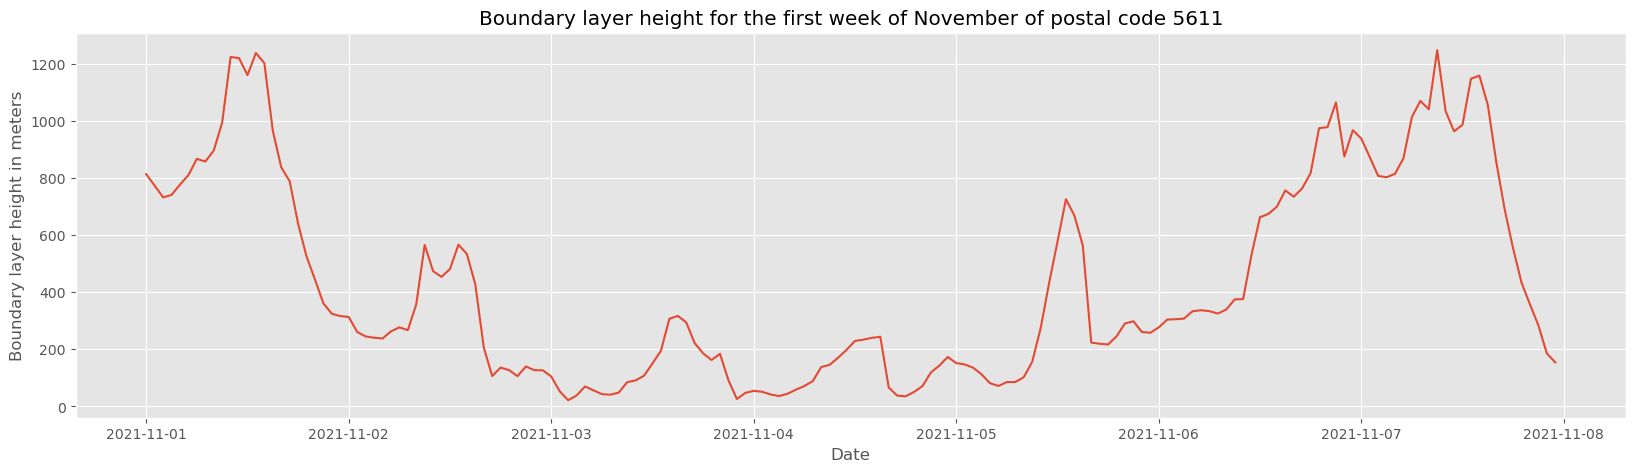

In [65]:
# Combined meto and air polution data for postalcode 5611
postalcode_df_meteo_air_polution = df_meteo_air_pollution[df_meteo_air_pollution['PC4'] == 5611]

# Combined data for the first week of november 2021 from postal code 5611 (24 * 7 = 168 entries)
one_week_postalcode_df_meteo_air_polution = postalcode_df_meteo_air_polution[postalcode_df_meteo_air_polution['date']. dt. strftime('%Y-%m')=='2021-11'].head(168)
    
plt.figure(figsize = (20 ,5))

plt.plot(one_week_postalcode_df_meteo_air_polution['date'], one_week_postalcode_df_meteo_air_polution['blh'])
 
# Adding Title to the Plot
plt.title('Boundary layer height for the first week of November of postal code 5611')

# Setting the X and Y labels
plt.xlabel('Date')
plt.ylabel('Boundary layer height in meters')
  
plt.show()

In the graph above you can see that almost every day at around noon the boundary layer height increases and decreases later at night. That is because the surface temperature at noon elevated lead to increased sensitive heat flux, and as a result, the boundary layer height will develop higher during daytime. 

<h4><font color=mediumvioletred> Visualize particulate matter smaller than 2.5 micrometers for the first week of November of postal code 5611</font></h4>

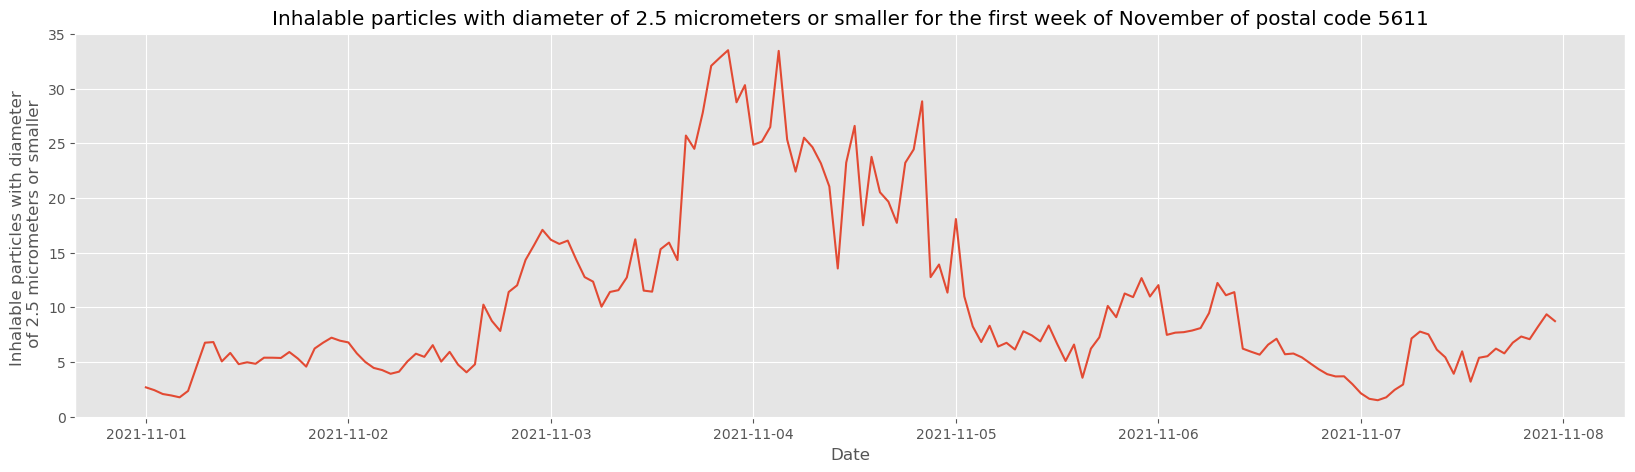

In [66]:
plt.figure(figsize = (20 ,5))

plt.plot(one_week_postalcode_df_meteo_air_polution['date'], one_week_postalcode_df_meteo_air_polution['pm2.5'])
 
# Adding Title to the Plot
plt.title('Inhalable particles with diameter of 2.5 micrometers or smaller for the first week of November of postal code 5611')

# Setting the X and Y labels
plt.xlabel('Date')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller')
  
plt.show()

In the graph above the particulate matter of 2.5 micrometer or smaller is visualized for the first week of November. You can see that almost every night the particals are lower then during the day. It is hard to see peaks in PM2.5 during the day but you can see a clearly difference between the particals at night and day. 

<h4><font color=mediumvioletred>Conclusion</font></h4>

After exploring and visualising the combined meteo- and pollution data, we came to the conclusion that the boundary layer height, the windspeed, the nitrogen dioxide in ug/m3, and the solar surface radiation downwards had the most corrolation on the PM2.5 values. Since this is the most important measurement of the pollution data, we devided that moving forward we are going to use this data in the air pollution prediction tool.

<h3><font color=steelblue>Air pollution dataset</font></h3>

<h4><font color=mediumvioletred>Read CSV files</font></h4>

In [67]:
df_ap = pd.read_csv("data/daily_pm25.csv")
# df_ap_per_date_per_postalcode = df_ap.groupby([pd.Grouper(freq='D', key='date'),
#                      'PC4']).mean()

<h4><font color=mediumvioletred>Rename column in df_ap dataset </font></h4>

In [68]:
df_ap.rename(columns={"tpm2.5_ugm3": "pm2.5"}, inplace=True)
df_ap.sample(5)

date   PC4      pm2.5
1564  X2021.04.15  5615   8.199228
2339  X2021.05.30  5617   7.139135
5582  X2021.04.18  5629  13.221501
9795  X2021.11.02  5652  13.020795
4152  X2021.05.18  5625  10.477654

<h4><font color=mediumvioletred>Format date column in df_ap dataset </font></h4>

In [69]:
df_ap['date'] = df_ap['date'].str.replace('X', '', regex=True)
df_ap['date'] = df_ap['date'].str.replace('.', '-', regex=True)
df_ap.sample(5)

date   PC4      pm2.5
10207  2021-12-19  5653  18.619118
2700   2021-05-26  5621   6.528590
4341   2021-11-23  5625  18.449175
408    2021-02-13  5612  16.983036
5417   2021-11-04  5628  17.208710

<h4><font color=mediumvioletred>Get some info about each column (type, number of null values..)</font></h4>

In [70]:
df_ap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12045 entries, 0 to 12044
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    12045 non-null  object 
 1   PC4     12045 non-null  int64  
 2   pm2.5   12045 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 282.4+ KB


<h4><font color=mediumvioletred>Get the generate descriptive statistics of the columns</font></h4>

In [71]:
df_ap.describe()

PC4         pm2.5
count  12045.000000  12045.000000
mean    5633.818182     12.561621
std       15.169287      9.077547
min     5611.000000      1.953800
25%     5622.000000      6.434049
50%     5631.000000      9.772749
75%     5646.000000     16.215052
max     5658.000000     58.178875

<h4><font color=mediumvioletred>Testing for Normality</font></h4>

Skewness per column:
PC4      0.133656
pm2.5    1.638690
dtype: float64


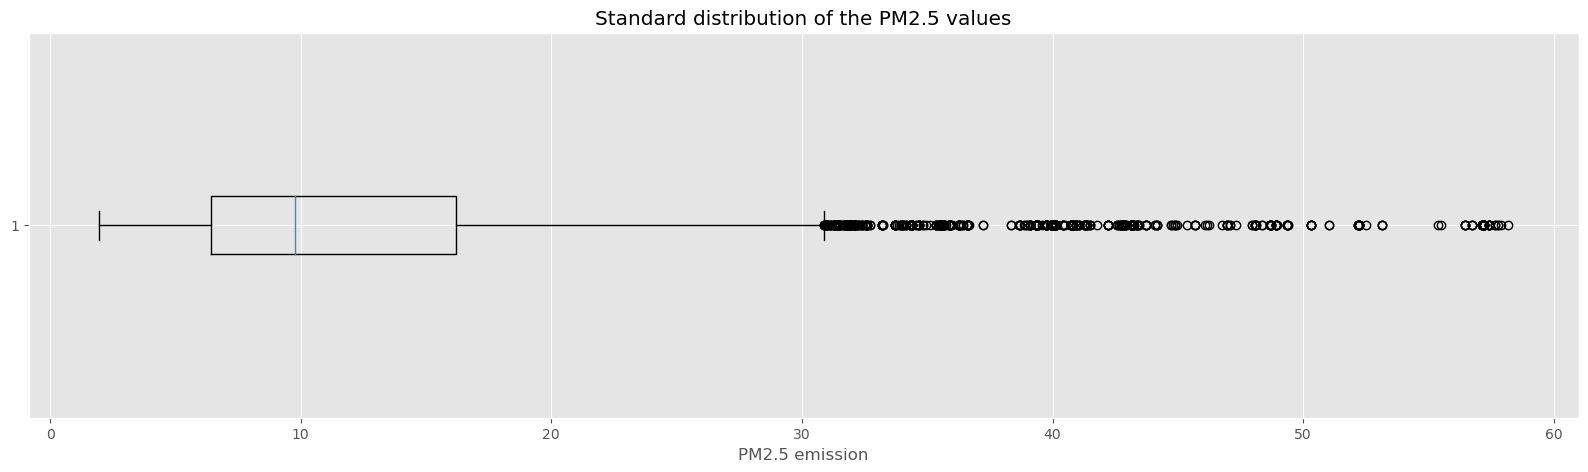

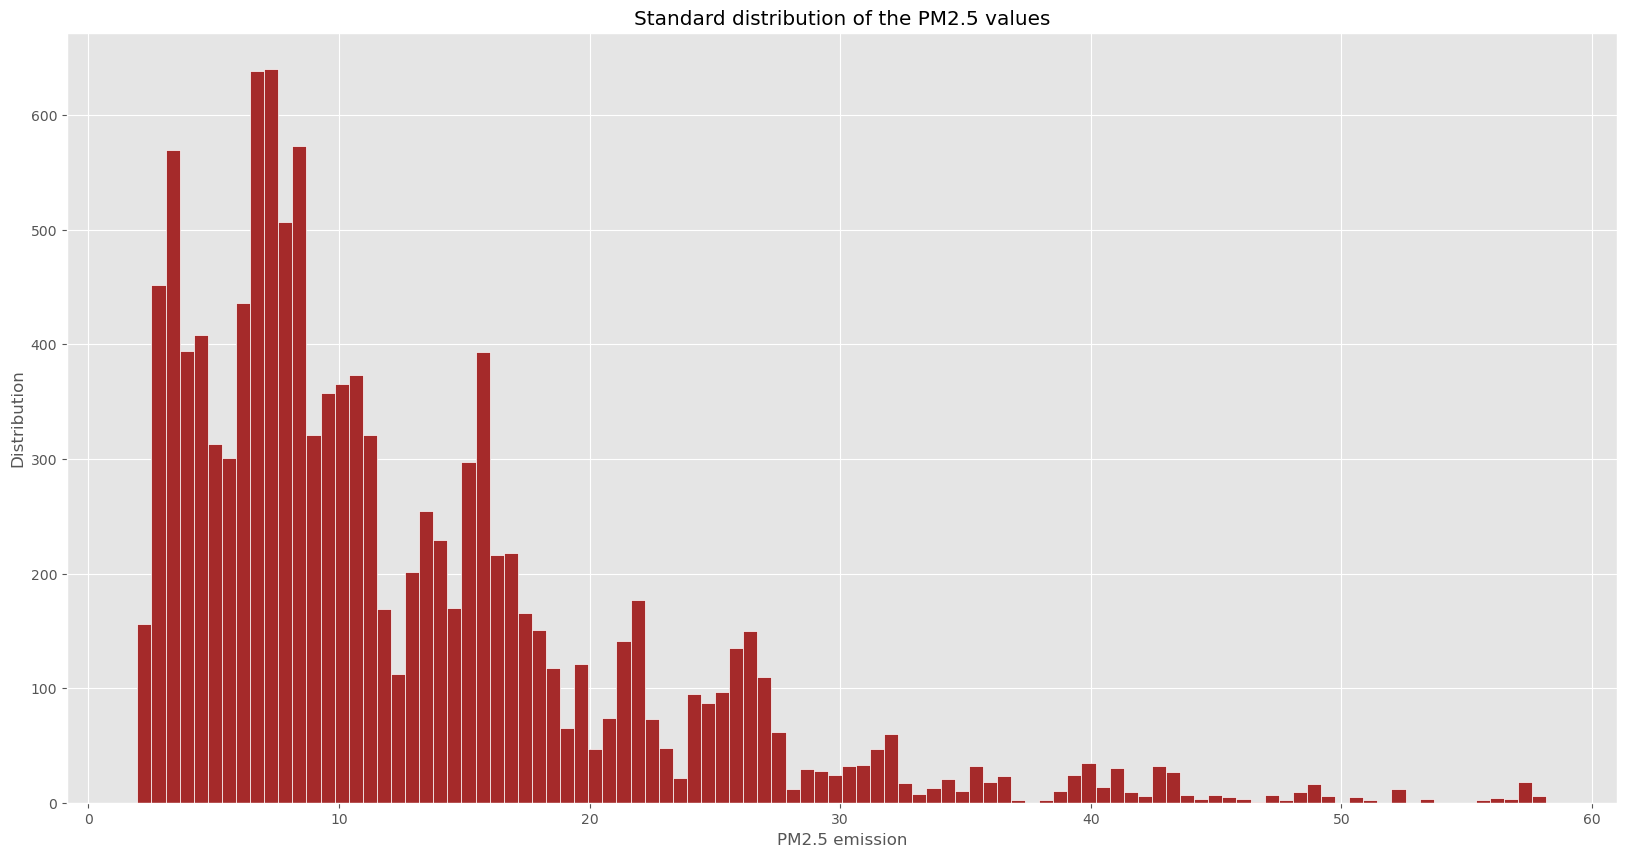

In [72]:
print("Skewness per column:")
print(df_ap.skew(numeric_only=True))

plt.figure(figsize=(20,5))
plt.boxplot( df_ap['pm2.5'], vert=False)
plt.title("Standard distribution of the PM2.5 values")
plt.xlabel("PM2.5 emission")
plt.show()

plt.figure(figsize=(20,10))
plt.hist(df_ap['pm2.5'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the PM2.5 values")
plt.xlabel("PM2.5 emission")
plt.ylabel("Distribution")
plt.show()

Most skewed data in the dataset is the PM2.5 data.<br>
There is a peak of 144 at the end of the tail. This could imply that anomalies exist in the data.<br>
These number values are unexpectedly high compared to what would be normal.<br> 

These anomalies could cause malfunctions in future model(s). Action could be taken to minimize the effect of these anomalies.

<h4><font color=mediumvioletred>Correlations in the dataset - Correlation matrix</font></h4>

In [73]:
df_ap.corr()

PC4     pm2.5
PC4    1.000000  0.000396
pm2.5  0.000396  1.000000

<h4><font color=mediumvioletred> Worst mean total pollution in different postal code areas</font></h4>

In [74]:
df_ap_sp = df_ap.groupby(['PC4']).mean(numeric_only=True)
print('Most populated areas with the pollution type:')
df_ap_sp = df_ap_sp.drop_duplicates()
df_ap_sp.reset_index().style.highlight_max(color = 'orange')

Most populated areas with the pollution type:


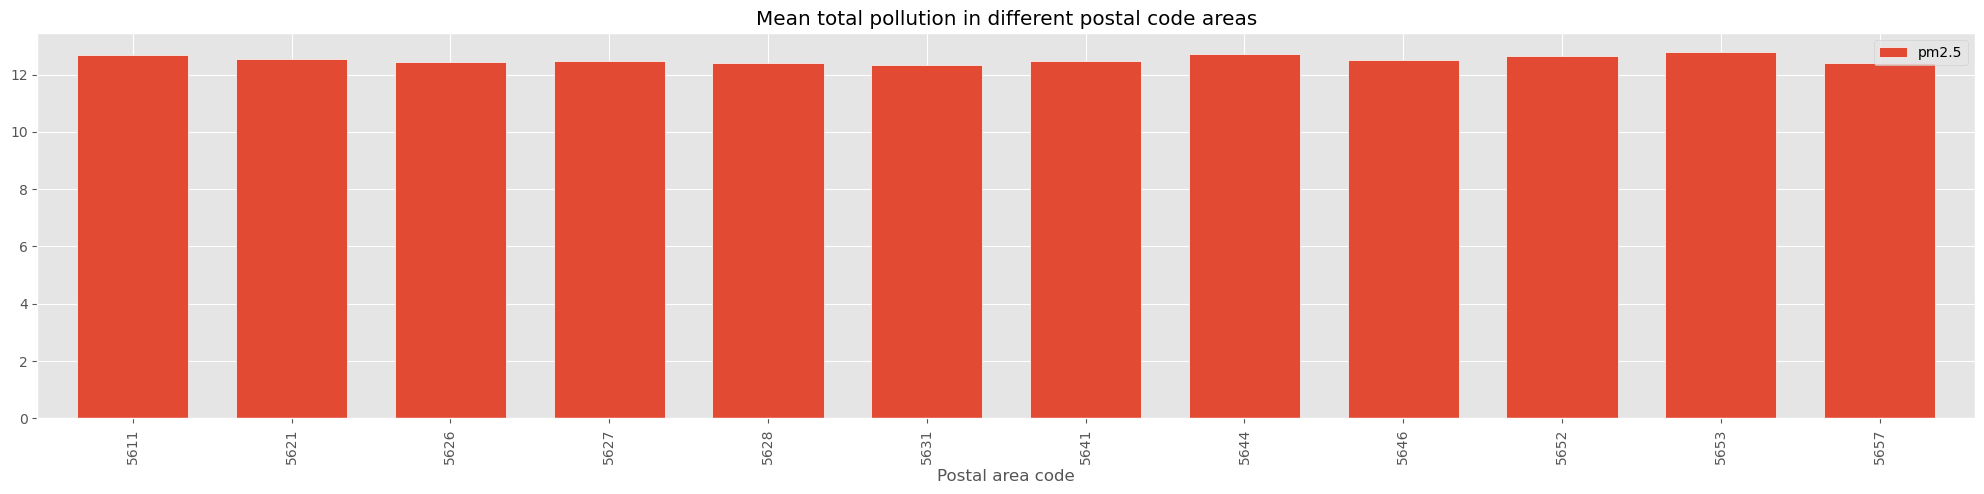

In [75]:
plot = df_ap_sp.plot.bar(xlabel= "Postal area code", legend=True, figsize=(25,5), width=0.7, edgecolor='white', title="Mean total pollution in different postal code areas")

There is a limited difference in air pollution between the different postal codes in Eindhoven.

<h4><font color=mediumvioletred> Most peak pollution in different postal code areas</font></h4>

In [76]:
df_ap_mp = df_ap.groupby(['PC4']).max(numeric_only=True)
print('Most polluted areas per pollution type:')
#Only grabs the first value, or none
print(df_ap_mp.idxmax())
df_ap_mp = df_ap_mp.drop_duplicates()
df_ap_mp.reset_index().style.highlight_max(color = 'orange')

Most polluted areas per pollution type:
pm2.5    5657
dtype: int64


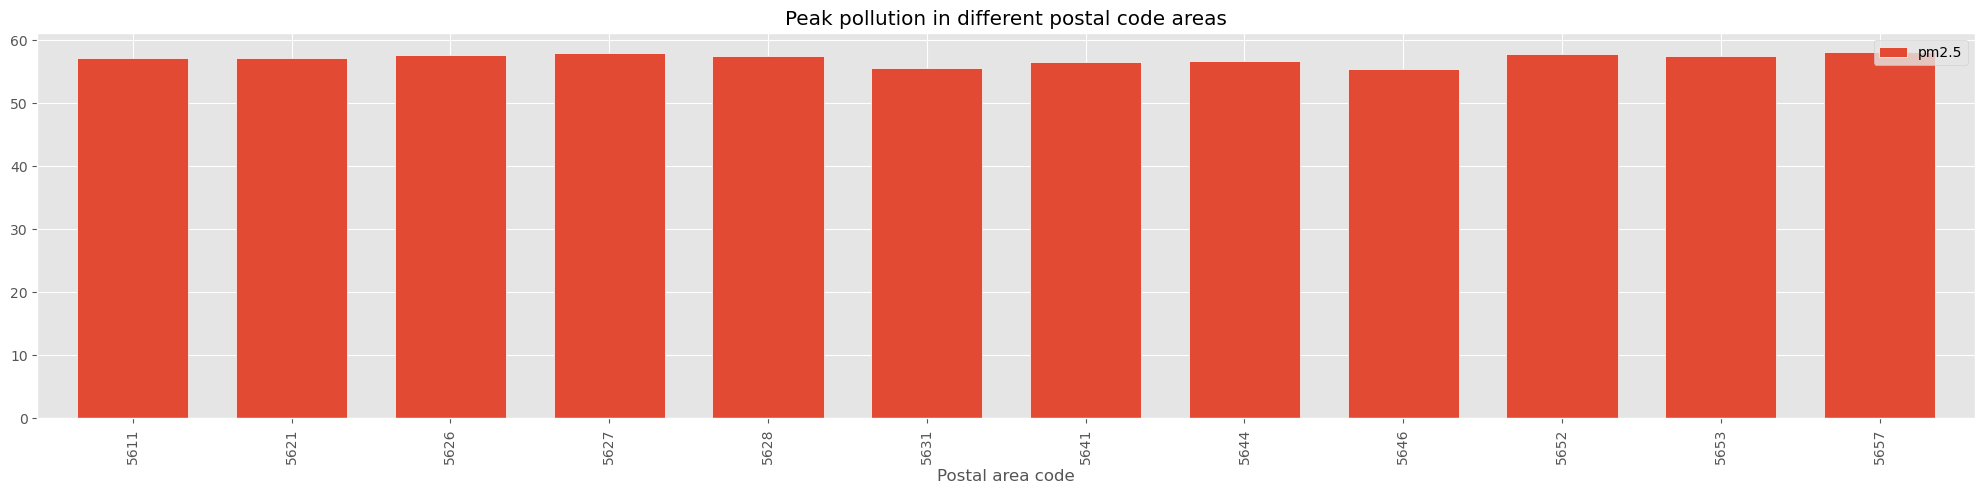

In [77]:
plot = df_ap_mp.plot.bar(xlabel= "Postal area code", legend=True, figsize=(25,5), width=0.7, edgecolor='white', title="Peak pollution in different postal code areas")

There is a limited difference in air pollution between the different postal codes in Eindhoven.

There are several instances of the PM2.5 pollution with the value of 144.709400.<br>
The PM2.5 sensor might be peaking, therefore, the taken measurement might be incorrect.

<h4><font color=mediumvioletred> Least pollution in different postal code areas</font></h4>

In [78]:
df_ap_lp = df_ap.groupby(['PC4']).min(numeric_only=True)

print('Least polluted areas per pollution type:')
#Only grabs the first value, or none
print(df_ap_lp.idxmin())

df_ap_lp = df_ap_lp.drop_duplicates()
df_ap_lp.reset_index().style.highlight_min(color = 'lightgreen')

Least polluted areas per pollution type:
pm2.5    5641
dtype: int64


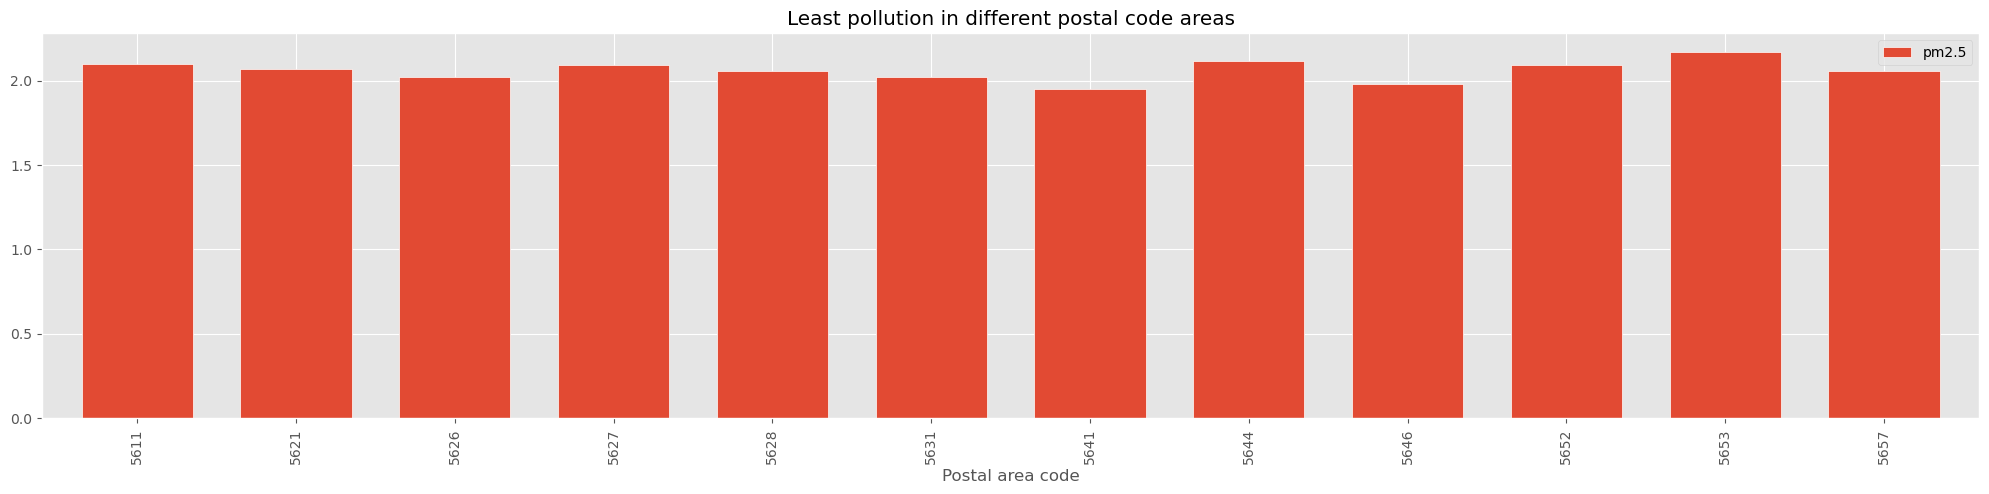

In [79]:
plot = df_ap_lp.plot.bar(xlabel= "Postal area code", legend=True, figsize=(25,5), width=0.7, edgecolor='white', title="Least pollution in different postal code areas")

There is a limited difference in air pollution between the different postal codes in Eindhoven.

The sulfur dioxide sensor is not always taking measurements.


<h4><font color=mediumvioletred>The average emission for each selected postal code on selected days</font></h4>

In [80]:
df_heat = df_ap
# START_DATE =  '2021-09-25'
# END_DATE = '2021-12-31'
# PCODES = [5611, 5626, 5644, 5654, 5658]

# Select rows between start and end date for each postal code
# mask = ((df_heat['date'] > START_DATE) & (df_heat['date'] <= END_DATE))
# df_heat = df_heat.loc[mask]
# df_heat = df_heat.loc[df_heat['PC4'].isin(PCODES)]

# Group by postal code and group by day
df_heat['date'] = pd.to_datetime(df_heat['date'], format='%Y/%m/%d %H:%M:%S')
gr_by_pc4_day = df_heat.groupby(['PC4', df_heat['date'].dt.date]).mean()
print(gr_by_pc4_day)

                     pm2.5
PC4  date                 
5611 2021-01-01  27.282682
     2021-01-02  36.258427
     2021-01-03  25.480267
     2021-01-04   9.571132
     2021-01-05  15.778516
...                    ...
5658 2021-12-27  14.607095
     2021-12-28   6.084734
     2021-12-29  10.178024
     2021-12-30   6.480275
     2021-12-31   8.219768

[12045 rows x 1 columns]


<h4><font color=mediumvioletred>Heatmap of the average emission for each selected postal code on selected days</font></h4>

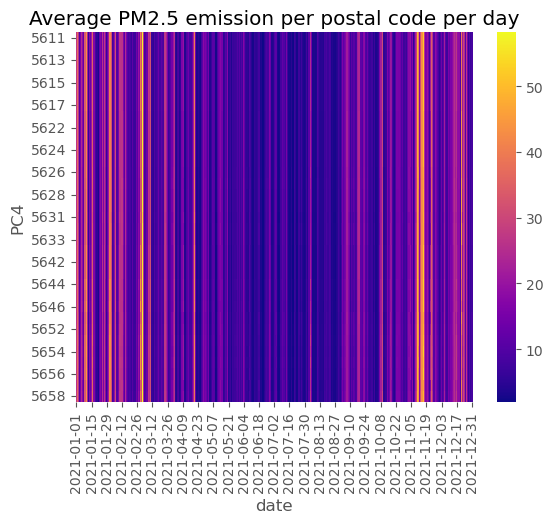

In [81]:
# Pivot the dataframe from long to wide form
heat = pd.pivot_table(gr_by_pc4_day, index='PC4', columns='date', values='pm2.5')

ax = plt.axes()
sns.heatmap(heat, annot=False, cmap='plasma', ax = ax)
ax.set_title('Average PM2.5 emission per postal code per day')
plt.show()



There is a limited difference in air pollution between different postal codes in Eindhoven.<br>
The emission of air pollutants for the city of Eindhoven is higher in December in comparison to the previous months in the dataset.


<h4><font color=mediumvioletred>Conclusion</font></h4>

The emission of air pollutants is higher during the Holiday season. 
Furthermore, there is little difference of the emission of air pollutants between postal codes in Eindhoven.
Anomalies exist in the dataset, which could lead to the malfunctioning of future model(s) based on this dataset.
Steps should be taken to minimize the risk associated with these anomalies. 

<h2><font color=slateblue> 5. Data Preparation </font></h2>

To prepare the data for the modelling process, the following steps must be taken:
1. Separate date and time in Meteo dataset.
2. Group areas and days in Meteo dataset (get averag wind direction, wind speed, sun radiation, boundary layer height).
3. Combine the three tables.
4. Extract date information day, month, year, day_of_week and day_of_year.
5. Handle empty values.
6. Remove/handle outliers in pm2.5.
 
The needed columns for modelling are: date (day, month, year), day_of_week, day_of_year, zipcode, average pm2.5, number of people, wind direction, wind speed, sun radiation, boundary layer height.

<h4><font color=mediumvioletred>Get sample of df_zichtop_air_pollution dataset</font></h4>

In [82]:
df_zichtop_air_pollution.sample(5)

PC4        date  people_number      pm2.5
7771  5646  2021-02-13         4274.0  16.388487
1209  5614  2021-09-01         6594.0   4.245551
4274  5627  2021-03-30         6889.0  15.605274
6345  5641  2021-08-16         6308.0   3.607192
9856  5656  2021-07-16        36404.0   3.154906

<h4><font color=mediumvioletred>Read meteo dataset</font></h4>

In [83]:
# read meteo dataset csv file
df_meteo = pd.read_csv("data/meteo.csv",
                    parse_dates=["date"])
df_meteo.head(5)

date   PC4          wd        ws         blh       tcc  ssrd
0 2021-01-01 00:00:00  5611  166.926422  1.892927   81.235970  0.944393   0.0
1 2021-01-01 01:00:00  5611  169.201538  2.008968   87.622505  0.978594   0.0
2 2021-01-01 02:00:00  5611  174.171677  2.226495   91.753311  0.977209   0.0
3 2021-01-01 03:00:00  5611  178.556778  2.440710   98.855789  0.966848   0.0
4 2021-01-01 04:00:00  5611  184.343124  2.482477  103.515137  0.994117   0.0

<h4><font color=mediumvioletred>Rename the date column to date_time </font></h4>

In [84]:
df_meteo.rename(columns={"date": "date_time"}, inplace=True)
df_meteo.sample(5)

date_time   PC4          wd        ws          blh       tcc  \
220981 2021-03-24 13:00:00  5651  223.336334  4.440934  1128.105347  0.242634   
284877 2021-07-09 21:00:00  5658  133.015854  1.215009    60.607140  0.787625   
121399 2021-11-10 07:00:00  5627  241.902786  2.465262   157.140457  0.854757   
83990  2021-08-03 14:00:00  5623   83.253685  0.689479  1134.908203  0.488590   
193252 2021-01-23 04:00:00  5644  253.008499  4.452077   429.315247  0.835749   

              ssrd  
220981  615.219375  
284877    0.000000  
121399    0.164121  
83990   552.888507  
193252    0.000000

<h4><font color=mediumvioletred>Separate date_time column to date and time </font></h4>

In [85]:
df_meteo["date"] = df_meteo["date_time"].dt.date.astype(str)
df_meteo["time"] = df_meteo["date_time"].dt.time.astype(str)
df_meteo.sample(5)

date_time   PC4          wd        ws          blh       tcc  \
199284 2021-10-01 12:00:00  5644  257.974976  5.555493   935.400696  1.000000   
7885   2021-11-25 13:00:00  5611  174.503098  1.899280   294.922241  0.947111   
68146  2021-10-12 10:00:00  5621  160.808853  2.953468  1009.908691  1.000000   
203302 2021-03-17 22:00:00  5645   89.379745  3.168437   375.337158  0.965396   
139531 2021-12-05 19:00:00  5629   39.186092  1.818363   170.763840  0.937186   

              ssrd        date      time  
199284  299.170451  2021-10-01  12:00:00  
7885     67.587873  2021-11-25  13:00:00  
68146    73.128672  2021-10-12  10:00:00  
203302    0.000000  2021-03-17  22:00:00  
139531    0.000000  2021-12-05  19:00:00

<h4><font color=mediumvioletred>Group wind directions</font></h4> 

In [86]:
def degToCompassNumerical(num):
    val=int((num/22.5)+.5)

    return (val % 16)

df_meteo['wd_group'] = df_meteo.apply(lambda row: degToCompassNumerical(row.wd), axis=1)
df_meteo.sample(5)

date_time   PC4          wd        ws          blh       tcc  \
204971 2021-05-26 11:00:00  5645  188.785416  5.189643  1510.378174  0.470870   
256900 2021-04-30 04:00:00  5655  192.347198  2.520039   246.635345  1.000000   
227291 2021-12-12 11:00:00  5651  221.558594  4.997029   457.873871  1.000000   
274531 2021-05-04 19:00:00  5657  200.290894  6.570831  1145.958740  0.336407   
96922  2021-01-24 10:00:00  5625  189.928116  3.994387   546.829163  0.884623   

              ssrd        date      time  wd_group  
204971  681.646944  2021-05-26  11:00:00         8  
256900    0.000000  2021-04-30  04:00:00         9  
227291   27.161046  2021-12-12  11:00:00        10  
274531   32.092995  2021-05-04  19:00:00         9  
96922   112.389583  2021-01-24  10:00:00         8

wd_group meaning which direction
0=N, 1=NNE, 2=NE, 3=ENE, 4=E, 5=ESE, 6=SE, 7=SSE, 8=S, 9=SSW, 10=SW, 11=WSW, 12=W, 13=WNW, 14=NW, 15=NNW

<h4><font color=mediumvioletred>Group Meteo dataset by area and date</font></h4>

In [87]:
df_meteo_grouped = df_meteo.groupby(["PC4", "date"]).agg({"wd": "mean", "ws": "mean", "ssrd": "mean", "blh": "mean"}).reset_index()
df_meteo_grouped['wd_group'] = df_meteo_grouped.apply(lambda row: degToCompassNumerical(row.wd), axis=1)
df_meteo_grouped.sample(5)

PC4        date          wd        ws        ssrd         blh  wd_group
2007  5616  2021-07-02  203.261907  2.085195  147.863282  432.863083         9
5927  5631  2021-03-29  223.612175  4.416476  202.123704  508.657013        10
7417  5642  2021-04-28   41.501071  3.703852  249.888946  599.242436         2
5238  5628  2021-05-09  269.649733  4.217798  252.296602  641.725733        12
4543  5626  2021-06-13   91.610834  1.416720  330.873603  553.413409         4

In [88]:
df_meteo_grouped.dtypes

PC4           int64
date         object
wd          float64
ws          float64
ssrd        float64
blh         float64
wd_group      int64
dtype: object

<h4><font color=mediumvioletred>Merge df_zichtop_air_pollution and df_meteo_grouped datasets</font></h4>

In [89]:
df_merged = pd.merge(df_zichtop_air_pollution[["PC4", "date", "people_number", "pm2.5"]], 
                     df_meteo_grouped[["PC4","date", "wd", "ws", "ssrd", "blh"]], 
                     on=["PC4", "date"])

<h4><font color=mediumvioletred>Get a sample of the merged datasets</font></h4>

In [90]:
df_merged.sample(5)

PC4        date  people_number      pm2.5          wd        ws  \
8146   5651  2021-04-07         4033.0   5.581223  171.580036  5.762371   
6331   5641  2021-08-02         4196.0   4.231642  151.772270  1.790305   
9693   5656  2021-02-03        13467.0   7.533784  216.532775  4.098641   
10345  5658  2021-02-11         1831.0  26.969429   59.581354  2.349525   
4830   5629  2021-01-01         2524.0  25.889505  204.556705  2.902236   

             ssrd         blh  
8146   154.428300  884.049767  
6331   175.807897  475.081583  
9693    16.570958  552.343044  
10345  101.897975  194.296301  
4830    35.350118  236.692484

<h4><font color=mediumvioletred>Create a method to extract date information</font></h4>

Since we saw a pattern in pm2.5 over different days of week, we decided to add a column that represents the day of the week.

Monday = 0,
Tuesday = 1,
Wednesday = 2,
Thursday = 3,
Friday = 4,
Saturday = 5,
Sunday = 6

We also seperated year, month and day so they can be used in the model.

The day_of_year column was added to track events and holidays as they are usually more busy and could have an impact on air quality.

Finally, we dropped the date column as it is no longer needed.

In [91]:
def extract_date_information(df):
    # convert date type to datetime     
    df["date"] = df["date"].astype("datetime64[ns]")
    
    # sort DataFrame in date order
    df.sort_values(by=["date"], inplace=True, ascending=True)
    
    # extract date info
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["day_of_week"] = df["date"].dt.day_of_week
    df["day_of_year"] = df["date"].dt.dayofyear

    # now we've enriched our DataFrame with date time features, we can remove 'date'
    df.drop("date", axis=1, inplace=True)
    
    return df

<h4><font color=mediumvioletred>Extract date information for df_merged_grouped dataframe</font></h4>

In [92]:
df_merged_numerical = extract_date_information(df_merged)
df_merged_numerical.head()

PC4  people_number      pm2.5          wd        ws       ssrd  \
0      5611         6671.0  27.282682  203.334312  2.886824  35.783607   
9660   5656         9330.0  27.052551  202.914324  2.885721  36.077402   
10304  5658         1539.0  26.888561  203.860565  2.900199  35.915225   
322    5612         5478.0  27.282682  203.603766  2.890154  35.685987   
3542   5625         3793.0  26.533379  204.119216  2.896506  35.493932   

              blh  year  month  day  day_of_week  day_of_year  
0      241.558209  2021      1    1            4            1  
9660   243.613262  2021      1    1            4            1  
10304  240.125790  2021      1    1            4            1  
322    240.507430  2021      1    1            4            1  
3542   238.454701  2021      1    1            4            1

<h4><font color=mediumvioletred>Checking for empty values</font></h4>

In [93]:
df_merged.isnull().sum()

PC4              0
people_number    0
pm2.5            0
wd               0
ws               0
ssrd             0
blh              0
year             0
month            0
day              0
day_of_week      0
day_of_year      0
dtype: int64

<h4><font color=mediumvioletred>Testing for normality dataframe</font></h4>

In [94]:
df_merged.describe()

PC4  people_number         pm2.5            wd            ws  \
count  10626.000000   10626.000000  10626.000000  10626.000000  10626.000000   
mean    5633.818182    8987.799642     12.055229    172.282659      3.529499   
std       15.169371    6032.506961      9.093147     72.871736      1.448399   
min     5611.000000     475.000000      1.953800     14.409862      1.113684   
25%     5622.000000    4760.500000      6.093740    113.190429      2.469868   
50%     5631.000000    7329.500000      9.087465    186.135220      3.261523   
75%     5646.000000   11584.000000     15.650513    228.597053      4.485780   
max     5658.000000   52402.000000     58.178875    342.018748      9.473761   

               ssrd           blh     year         month           day  \
count  10626.000000  10626.000000  10626.0  10626.000000  10626.000000   
mean     135.515705    566.744009   2021.0      5.832298     15.366460   
std       81.172705    246.216352      0.0      3.060075      8.749992   
min        4.423128    104.354365   2021.0      1.000000      1.000000   
25%       66.595104    393.447418   2021.0      3.000000      8.000000   
50%      126.323163    553.247469   2021.0      6.000000     15.000000   
75%      200.612562    704.359352   2021.0      8.000000     23.000000   
max      332.715429   1584.163956   2021.0     11.000000     31.000000   

        day_of_week   day_of_year  
count  10626.000000  10626.000000  
mean       3.000000    161.500000  
std        2.000094     92.957319  
min        0.000000      1.000000  
25%        1.000000     81.000000  
50%        3.000000    161.500000  
75%        5.000000    242.000000  
max        6.000000    322.000000

In [95]:
print("Skewness per column:")
print(df_merged.skew(numeric_only=True))

Skewness per column:
PC4              0.133658
people_number    1.624079
pm2.5            1.796102
wd              -0.367631
ws               0.931342
ssrd             0.349565
blh              0.941426
year             0.000000
month            0.007193
day              0.065390
day_of_week      0.000000
day_of_year      0.000000
dtype: float64


<h4><font color=mediumvioletred>Testing for boundry layer height outliers</font></h4>

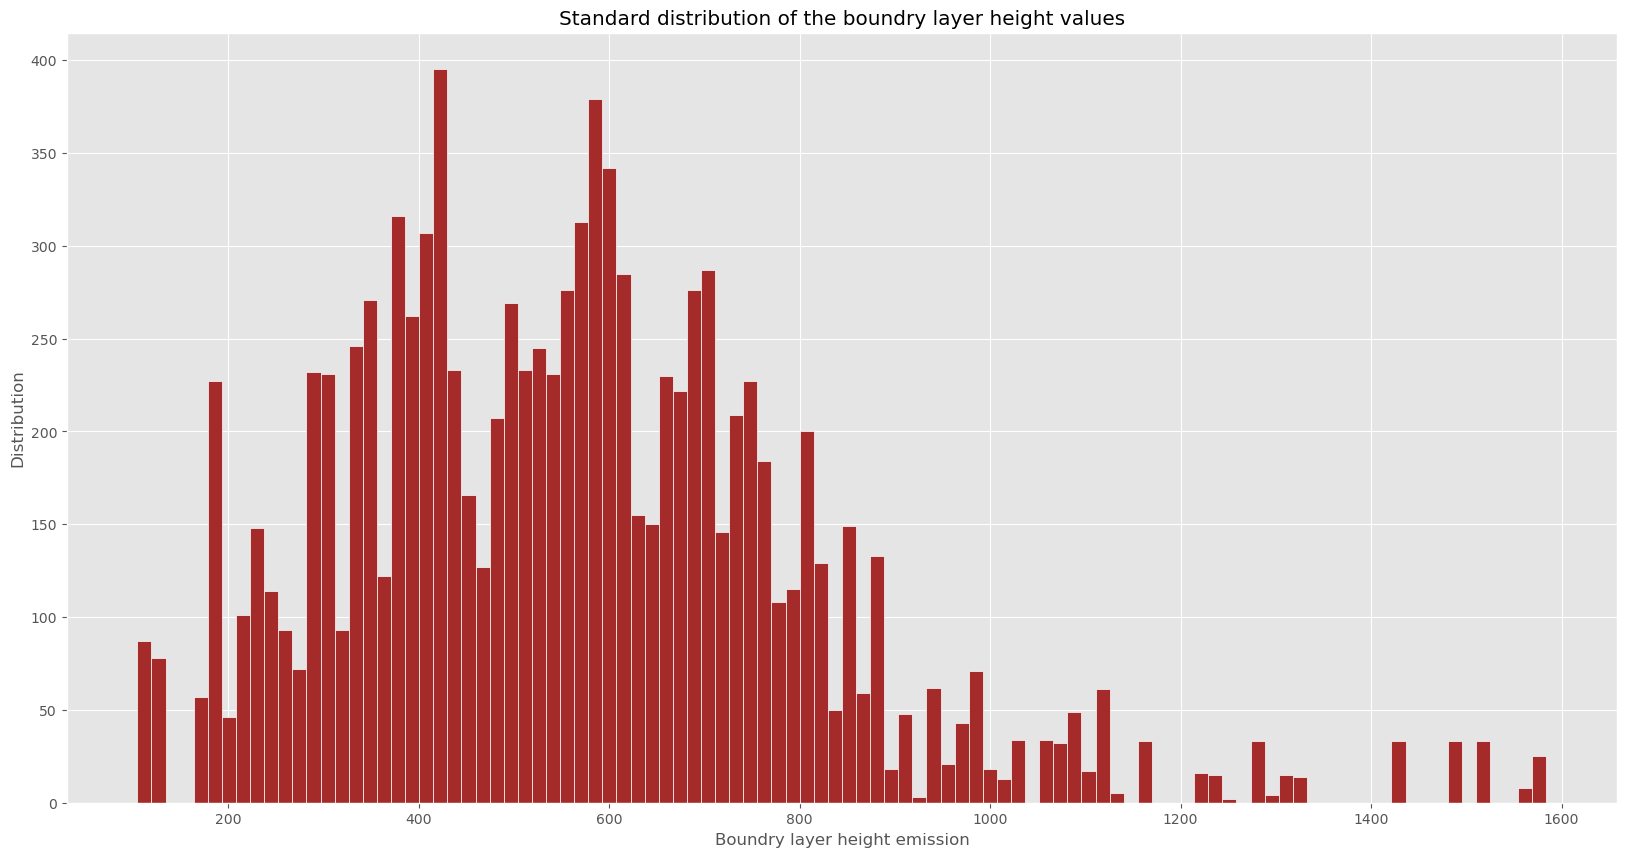

In [96]:
plt.figure(figsize=(20,10))
plt.hist(df_merged['blh'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the boundry layer height values")
plt.xlabel("Boundry layer height emission")
plt.ylabel("Distribution")
plt.show()

<h4><font color=mediumvioletred>Testing for people number outliers</font></h4>

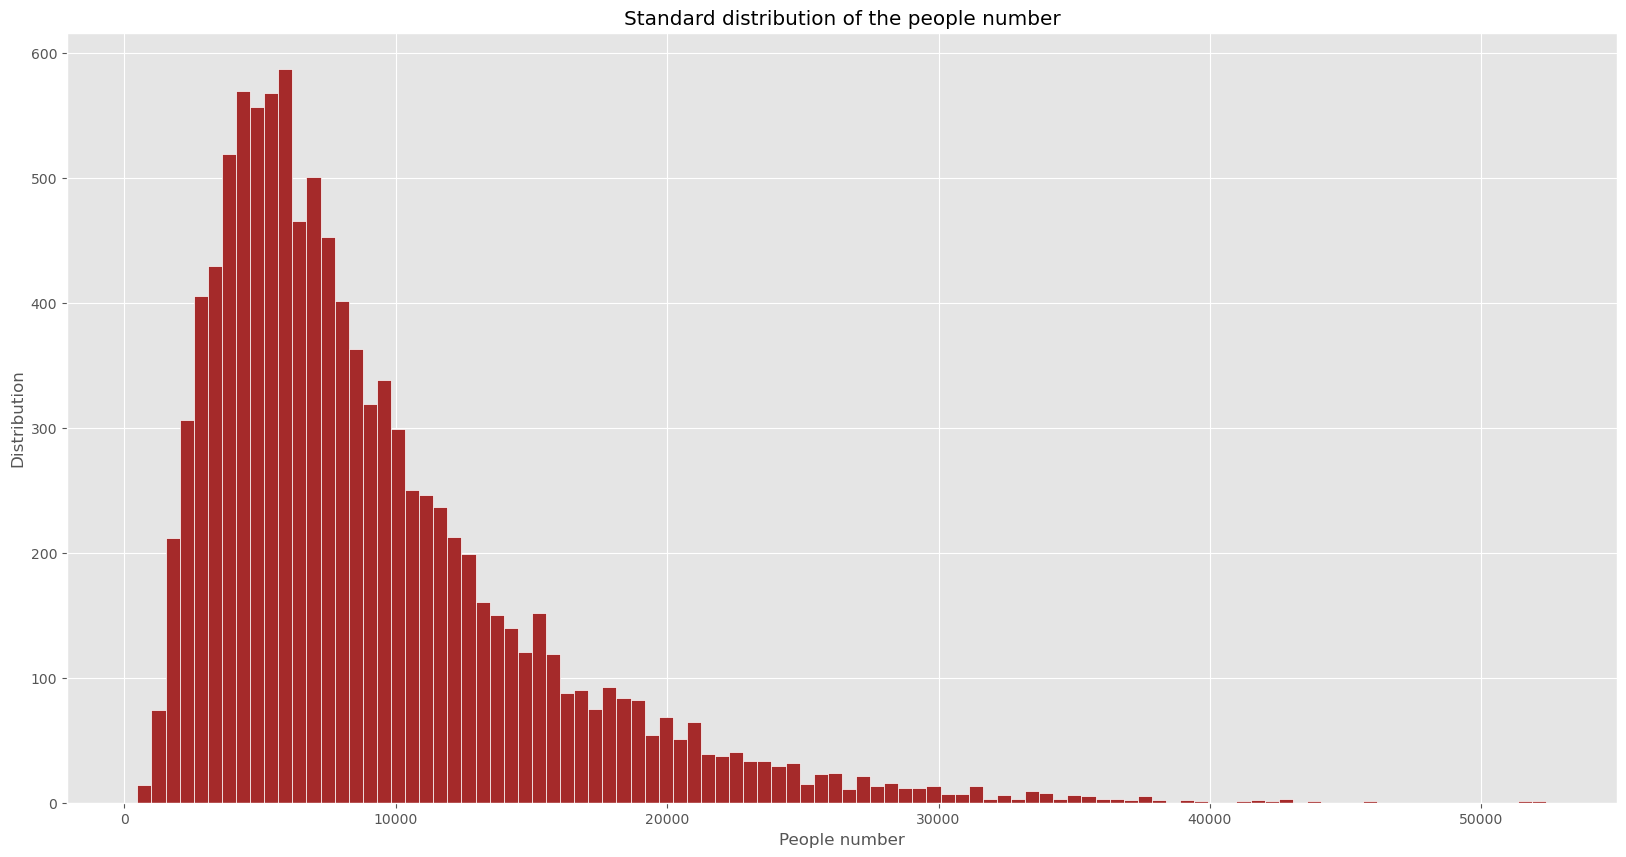

In [97]:

plt.figure(figsize=(20,10))
plt.hist(df_merged['people_number'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the people number")
plt.xlabel("People number")
plt.ylabel("Distribution")
plt.show()

<h4><font color=mediumvioletred>Testing for solar surface radiation outliers</font></h4>

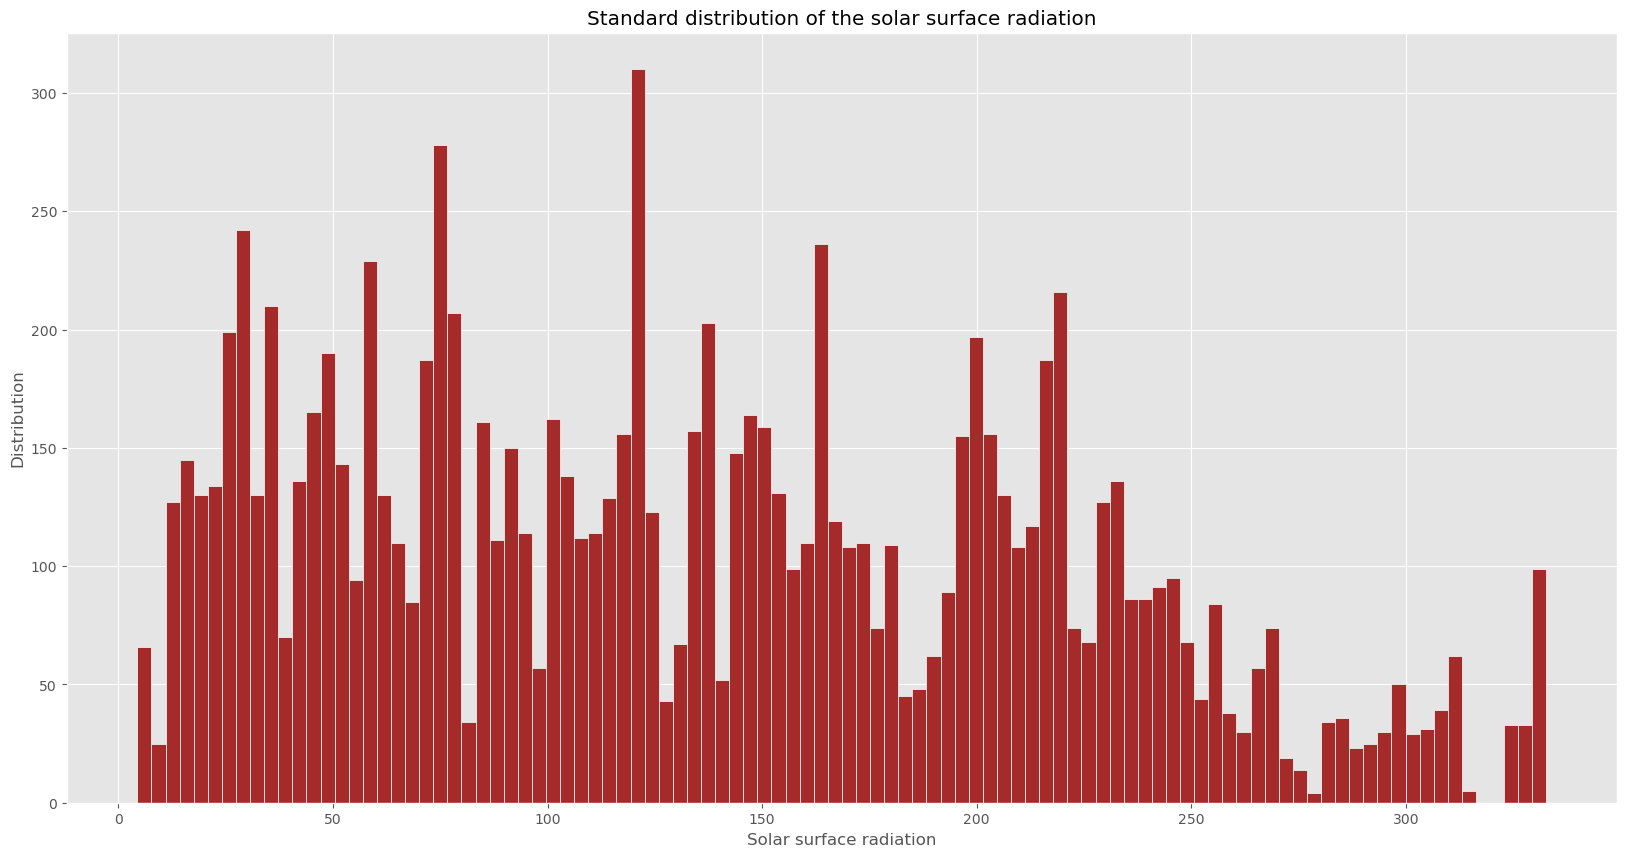

In [98]:
plt.figure(figsize=(20,10))
plt.hist(df_merged['ssrd'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the solar surface radiation")
plt.xlabel("Solar surface radiation")
plt.ylabel("Distribution")
plt.show()

There are a lot of numbers around zero. This is correct, because there is not sunshine at night. 

<h4><font color=mediumvioletred>Testing for PM2.5 emission outliers</font></h4>

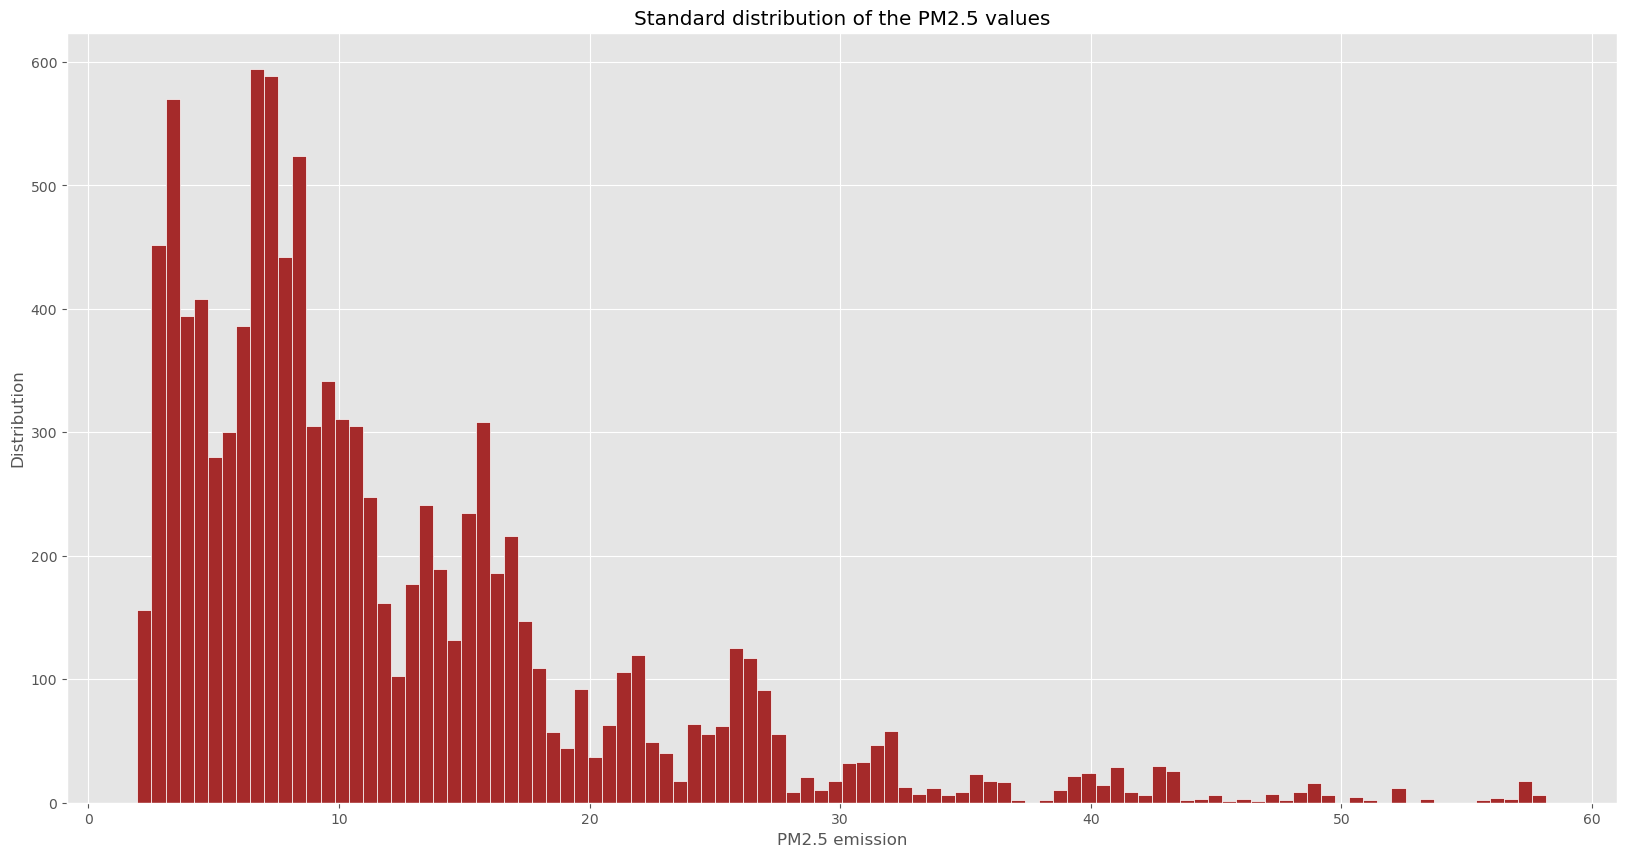

In [99]:
most_pm = df_merged.loc[df_merged['pm2.5'] == df_merged['pm2.5'].max()]

plt.figure(figsize=(20,10))
plt.hist(df_merged['pm2.5'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the PM2.5 values")
plt.xlabel("PM2.5 emission")
plt.ylabel("Distribution")
plt.show()

<h4><font color=mediumvioletred>Testing for wind speed outliers</font></h4>

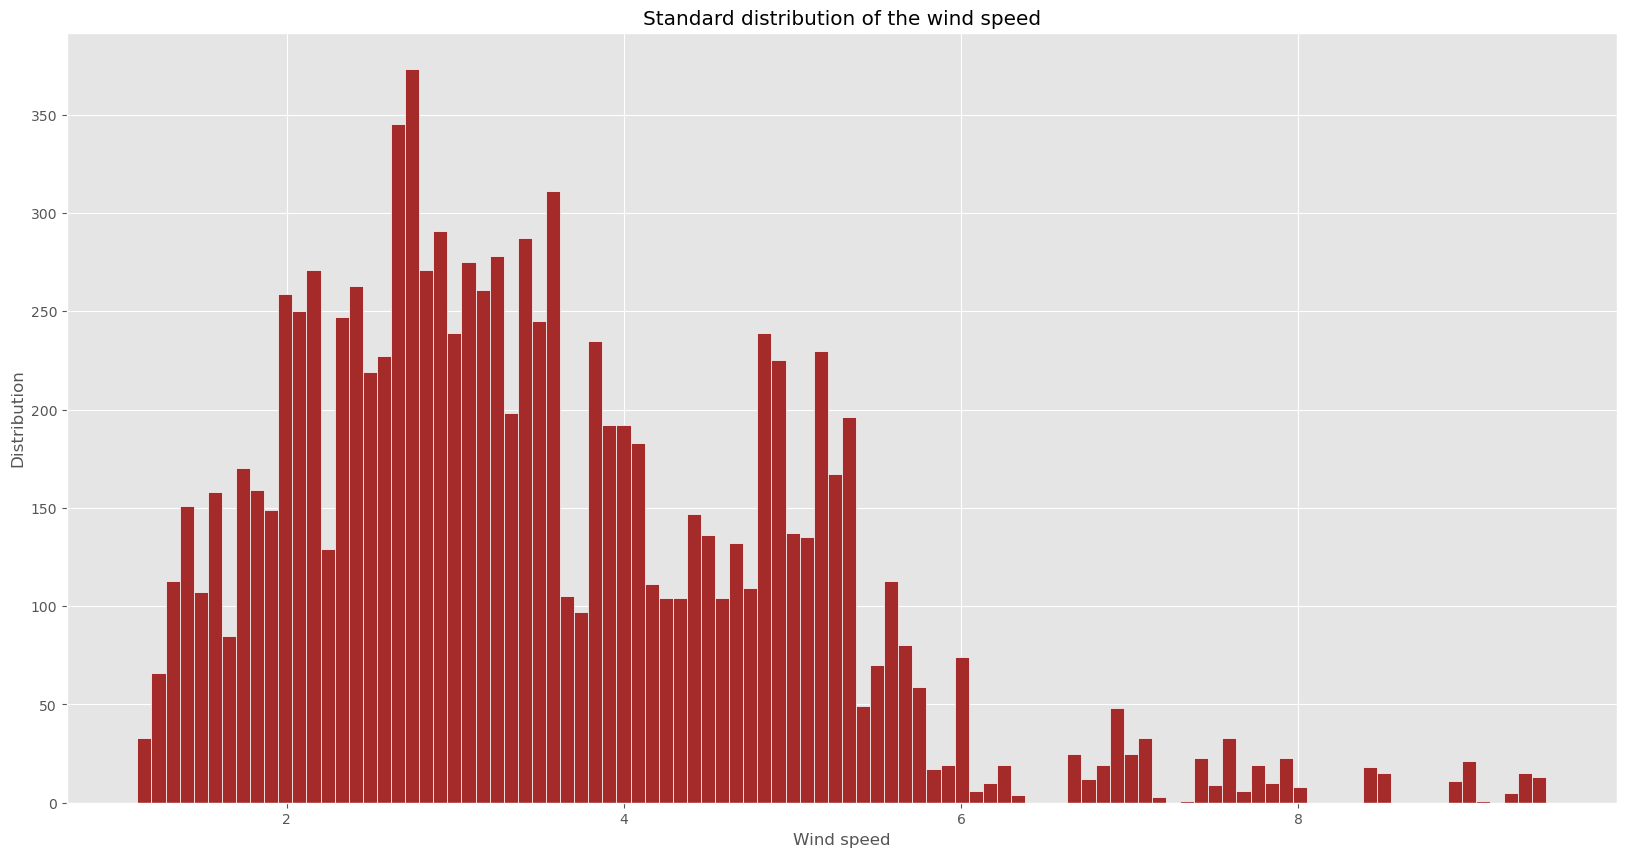

In [100]:
most_pm = df_merged.loc[df_merged['ws'] == df_merged['ws'].max()]

plt.figure(figsize=(20,10))
plt.hist(df_merged['ws'], edgecolor='white', color='brown', bins=100)
plt.title("Standard distribution of the wind speed")
plt.xlabel("Wind speed")
plt.ylabel("Distribution")
plt.show()

<h4><font color=mediumvioletred>Conclusion</font></h4>
There were no null values found by the project group. Furthermore, there were outliers, but they were consistent among all postal codes. The project group has therefore not made any changes to the values within the dataset.

<h4><font color=mediumvioletred>Export prepared dataframe to CSV</font></h4>

In [101]:
# Export prepared dataframe
df_merged_numerical.to_csv("data/df_merged_numerical_full_data.csv", index=False)

<h2><font color=slateblue> 6. Modelling </font></h2>

Link to [Modelling](modelling.ipynb)